# Assistente Virtual Bancário - CF Bank

## Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split

### Dataset cf_bank_clients.csv

In [2]:
df = pd.read_csv('./cf_bank_clients.csv')
df.head()

product_category_name   price  payment_sequential  \
0                     dentista  145.86                   3   
1  brinquedos_artigos_infantis   99.16                   1   
2       vestuario_e_acessorios  119.82                   1   
3                  combustível   50.84                   1   
4         loja_de_conveniencia   36.13                   1   

   payment_installments bank_clients  month  year  
0                    10         Jeff      2  2020  
1                     1        Norma      6  2018  
2                     1      Solomon      4  2015  
3                     8         Sita      8  2015  
4                     1      Richard      3  2016

In [3]:
df.shape

(103886, 7)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   product_category_name  103886 non-null  object 
 1   price                  103886 non-null  float64
 2   payment_sequential     103886 non-null  int64  
 3   payment_installments   103886 non-null  int64  
 4   bank_clients           103886 non-null  object 
 5   month                  103886 non-null  int64  
 6   year                   103886 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 5.5+ MB


In [5]:
df.describe()

price  payment_sequential  payment_installments          month  \
count  103886.000000       103886.000000         103886.000000  103886.000000   
mean      154.230474            1.098541              2.849142       6.502387   
std       213.670892            0.761052              2.687754       3.449394   
min         0.000000            1.000000              1.000000       1.000000   
25%        56.700000            1.000000              1.000000       4.000000   
50%       100.000000            1.000000              1.000000       6.000000   
75%       172.060000            1.000000              4.000000      10.000000   
max      6929.310000           29.000000             24.000000      12.000000   

                year  
count  103886.000000  
mean     2018.497748  
std         2.293036  
min      2015.000000  
25%      2016.000000  
50%      2018.000000  
75%      2021.000000  
max      2022.000000

## Análise dos Dados do Dataset

### Contagem total de compras por cliente

In [6]:
# Contagem total de compras por cliente
contagem_total = df["bank_clients"].value_counts()

# Contagem de compras por cliente, por mês e por ano
contagem_por_mes = df.groupby(["bank_clients", "year", "month"]).size().reset_index(name="Contagem")
contagem_por_ano = df.groupby(["bank_clients", "year"]).size().reset_index(name="Contagem")

print("Contagem total de compras por cliente:")
print(contagem_total)
print("\nContagem de compras por cliente, por mês:")
print(contagem_por_mes)
print("\nContagem de compras por cliente, por ano:")
print(contagem_por_ano)

Contagem total de compras por cliente:
bank_clients
Jianming    1107
Wendy       1101
Ursula      1094
Sara        1094
Gustavo     1093
            ... 
Cynthia      980
Khalid       979
Gregory      973
Gang         969
Nina         966
Name: count, Length: 100, dtype: int64

Contagem de compras por cliente, por mês:
     bank_clients  year  month  Contagem
0           Abdul  2015      1         4
1           Abdul  2015      2         7
2           Abdul  2015      3        16
3           Abdul  2015      4        10
4           Abdul  2015      5        11
...           ...   ...    ...       ...
9594       Zhihua  2022      8         9
9595       Zhihua  2022      9        14
9596       Zhihua  2022     10         9
9597       Zhihua  2022     11        16
9598       Zhihua  2022     12         9

[9599 rows x 4 columns]

Contagem de compras por cliente, por ano:
    bank_clients  year  Contagem
0          Abdul  2015       121
1          Abdul  2016       141
2          Abdul  20

In [7]:
contagem_total.head()

bank_clients
Jianming    1107
Wendy       1101
Ursula      1094
Sara        1094
Gustavo     1093
Name: count, dtype: int64

In [8]:
contagem_por_mes.head()

bank_clients  year  month  Contagem
0        Abdul  2015      1         4
1        Abdul  2015      2         7
2        Abdul  2015      3        16
3        Abdul  2015      4        10
4        Abdul  2015      5        11

In [9]:
contagem_por_ano.head()

bank_clients  year  Contagem
0        Abdul  2015       121
1        Abdul  2016       141
2        Abdul  2017       145
3        Abdul  2018       127
4        Abdul  2019       137

### Maiores Categorias de Gastos por Ano

#### Extrair anos únicos

In [10]:
# Extrair anos únicos
unique_years = df['year'].unique()
print("Anos únicos:", unique_years)

Anos únicos: [2020 2018 2015 2016 2017 2019 2021 2022]


#### maiores_categorias_ano(year)

In [11]:
def maiores_categorias_ano(year):
# Filtrar o ano específico desejado
    df_year = df[df['year'] == year]

    # Identificar as 10 maiores product_category_name de produtos
    top_10_product_category_name = df_year['product_category_name'].value_counts().nlargest(10).index

    # Agrupar os dados por mês, product_category_name e year, calculando o preço total para cada categoria em cada mês
    monthly_category = df_year.groupby(['month', 'product_category_name', 'year'])['price'].sum().reset_index()

    # Filtrar apenas as 10 maiores product_category_name para cada mês
    top_categories_df = pd.DataFrame()
    for month in range(1, 13):
        top_categories = monthly_category[(monthly_category['month'] == month) &
                                          (monthly_category['product_category_name'].isin(top_10_product_category_name))]
        top_categories_df = pd.concat([top_categories_df, top_categories])

    # Plotar gráfico de linhas para cada categoria com rótulos para os valores
    plt.figure(figsize=(16, 6))
    for category in top_categories_df['product_category_name'].unique():
        category_df_jian = top_categories_df[top_categories_df['product_category_name'] == category]
        plt.plot(category_df_jian['month'], category_df_jian['price'], label=category)

        # Adicionar rótulos aos valores no gráfico
        for i, price in enumerate(category_df_jian['price']):
            plt.text(category_df_jian.iloc[i]['month'], price, str(round(price, 2)), ha='center', va='bottom')

    plt.xlabel('Mês')
    plt.ylabel('Preço Total')
    plt.title(f'Análise Temporal das 10 Maiores Categorias em {year}')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

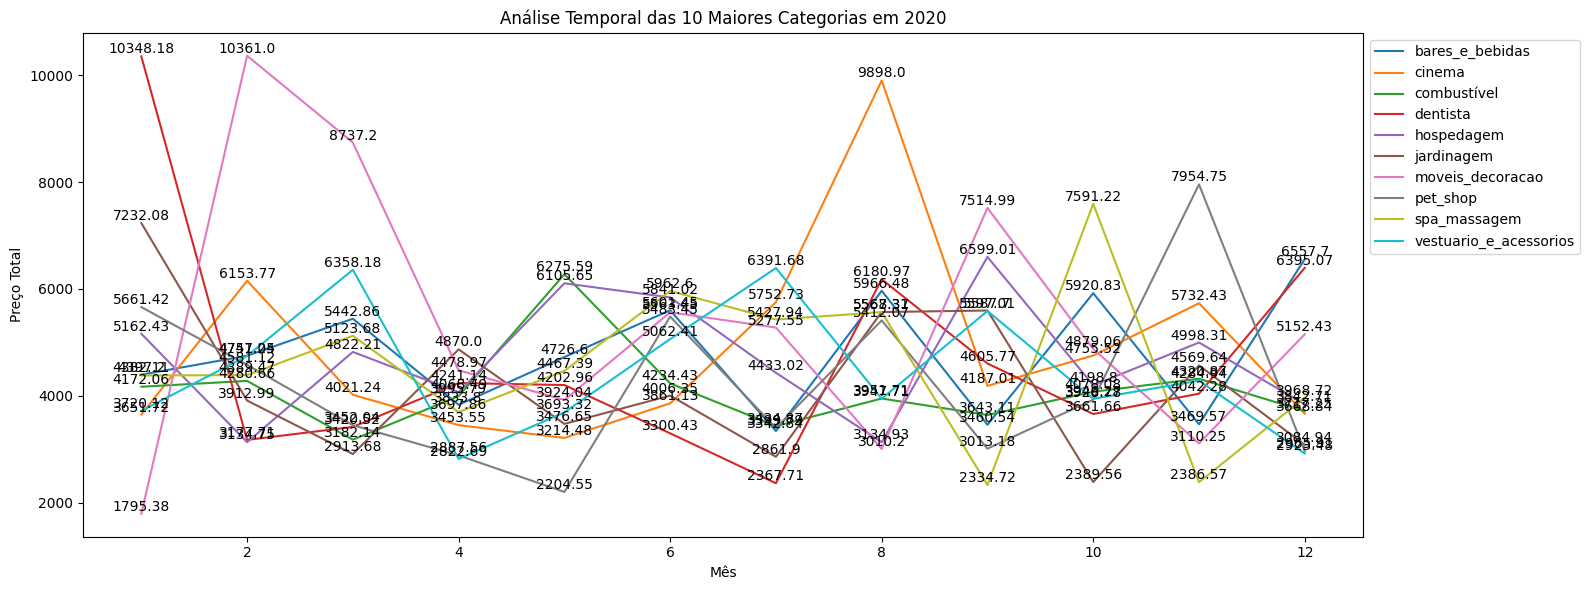

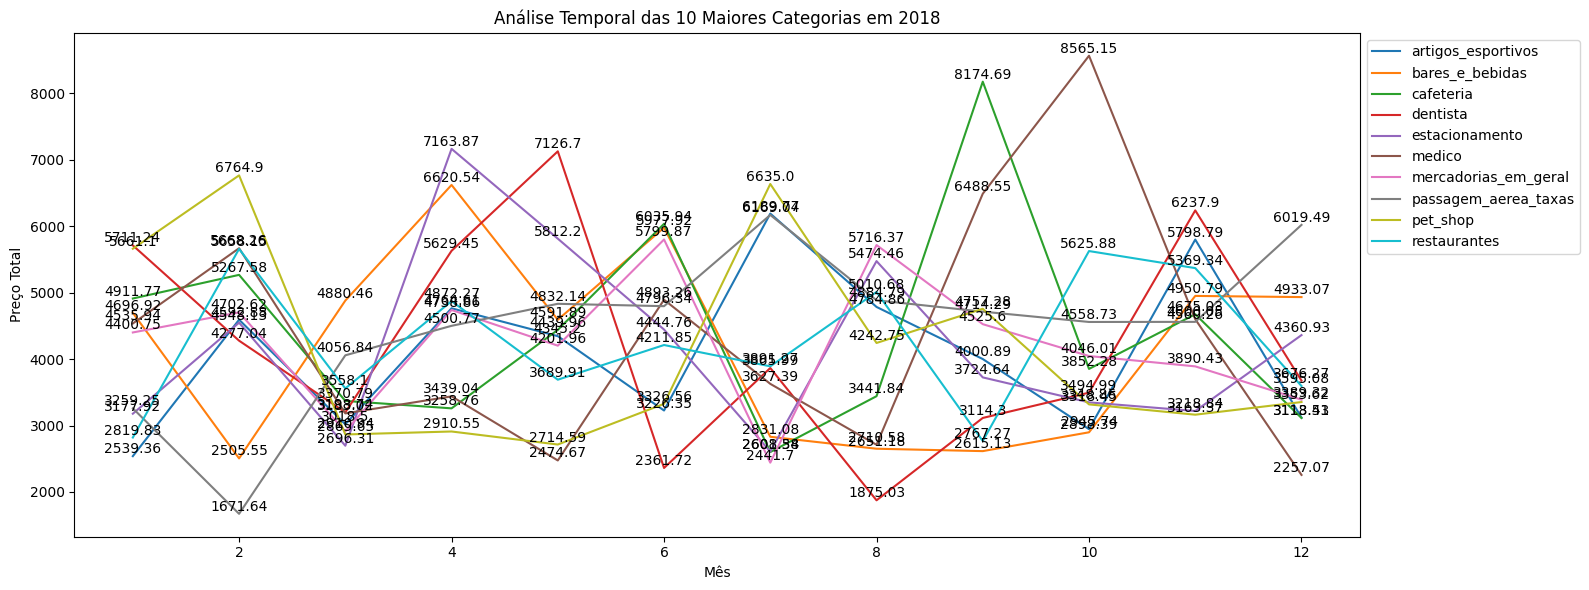

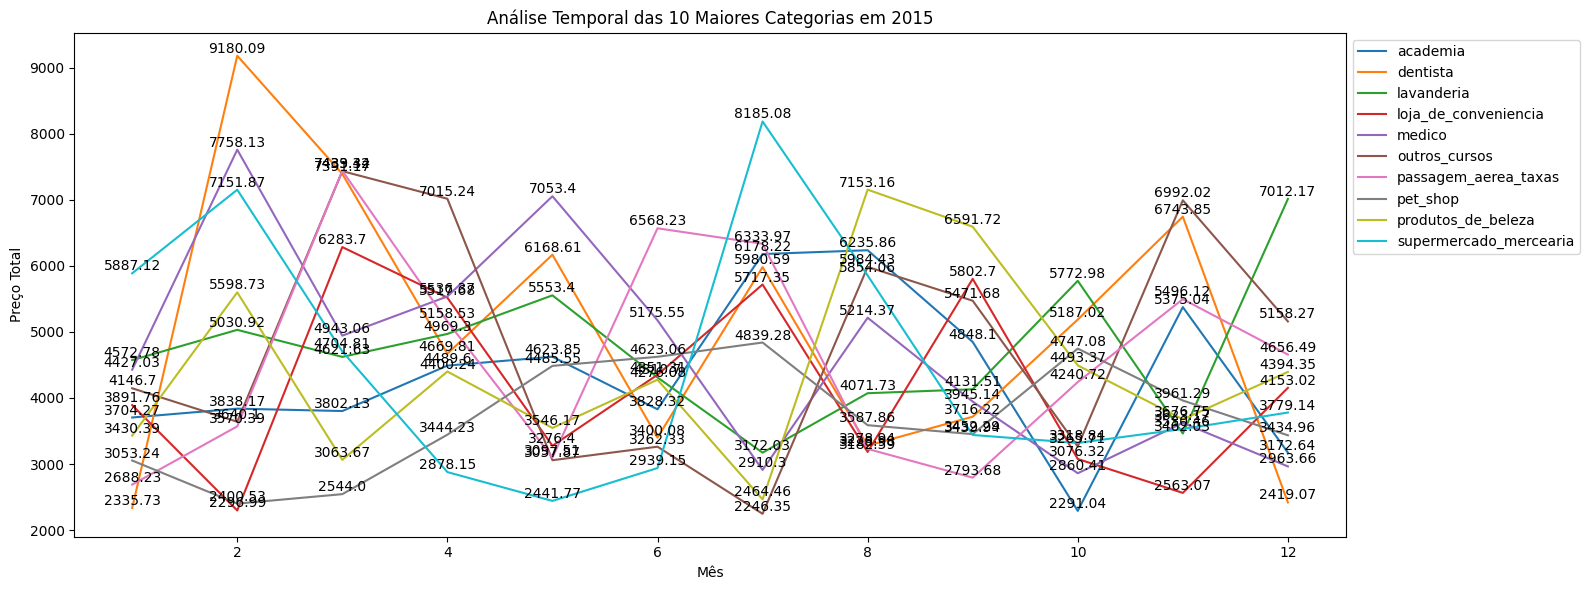

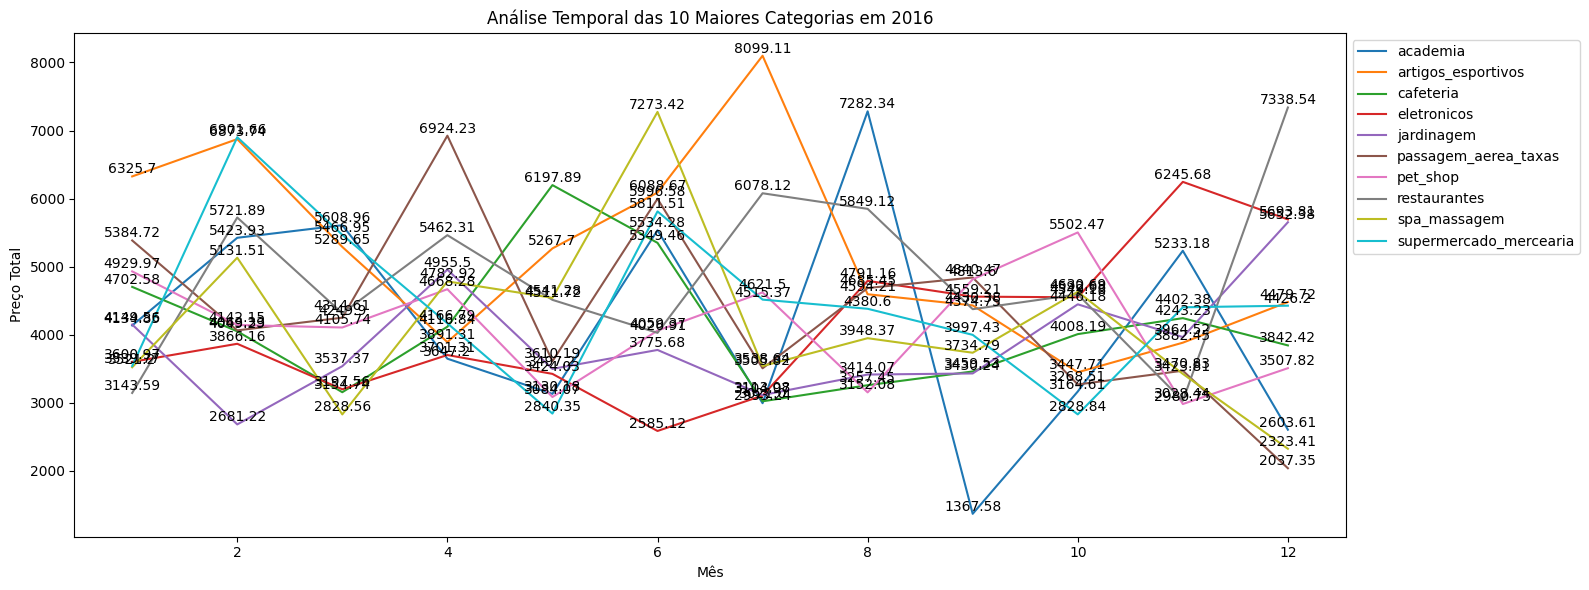

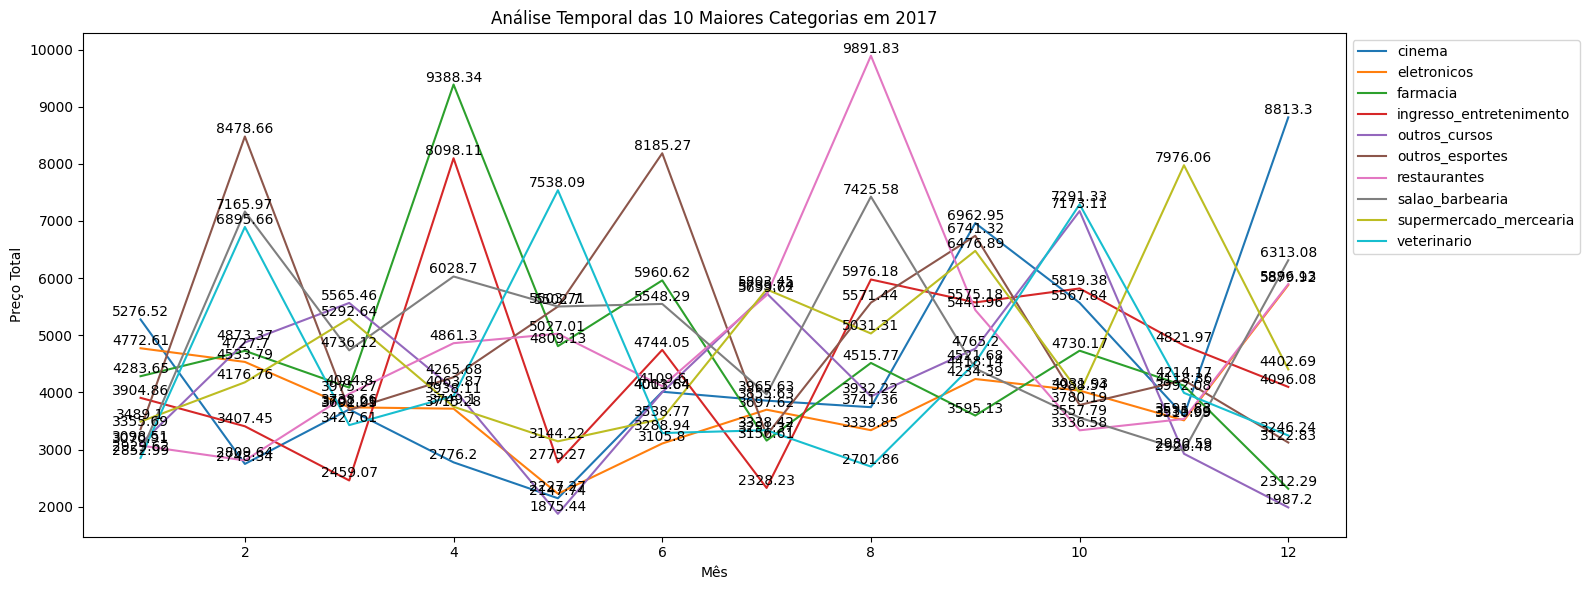

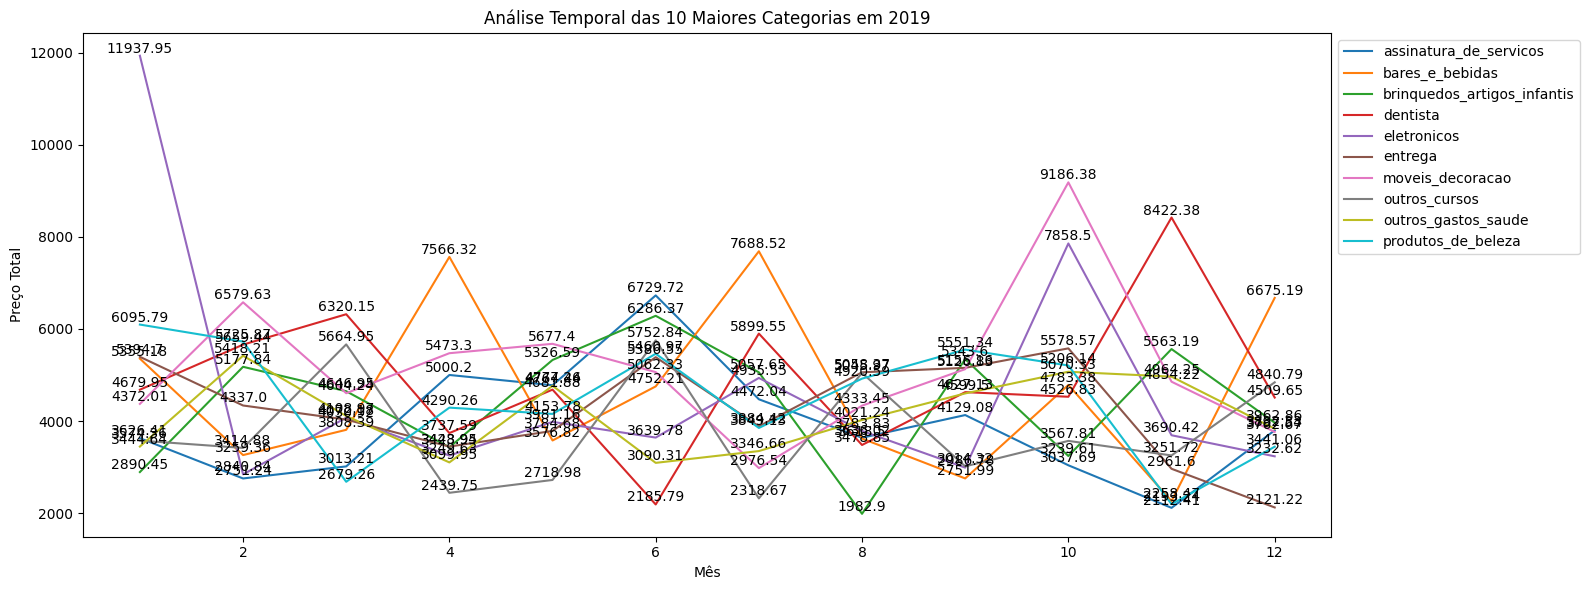

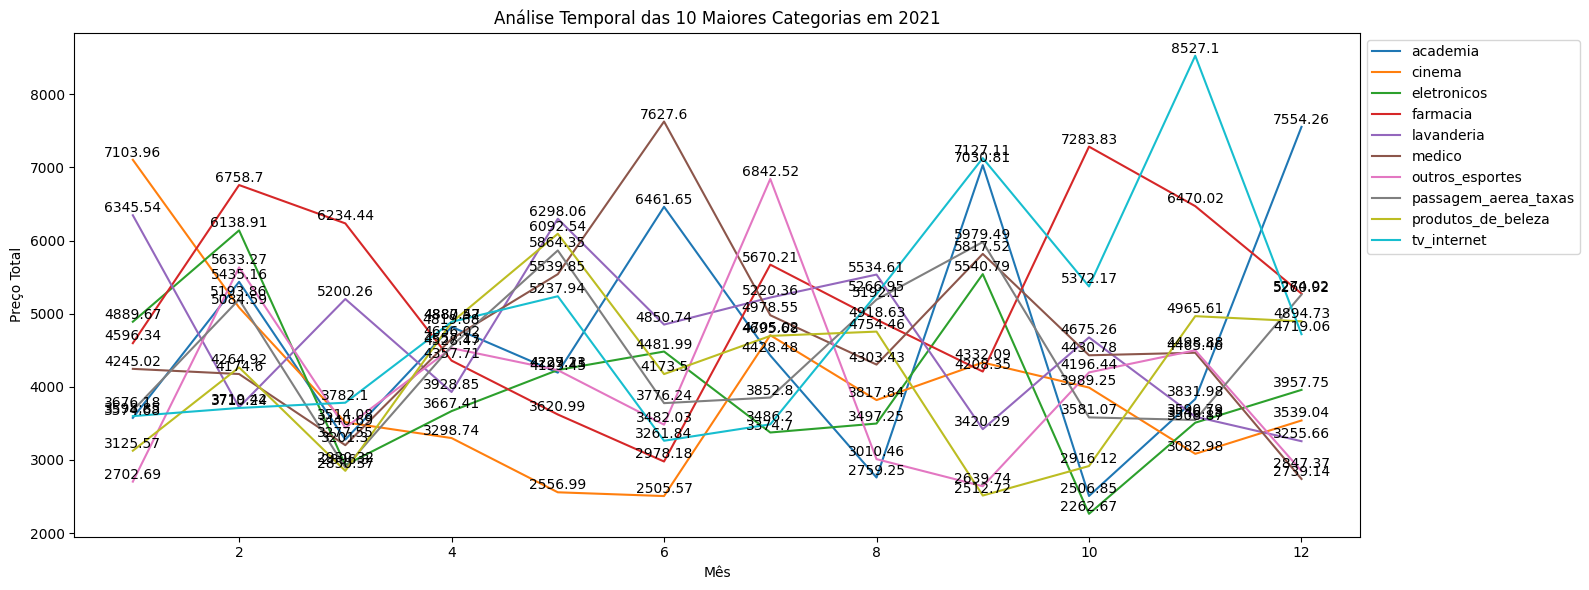

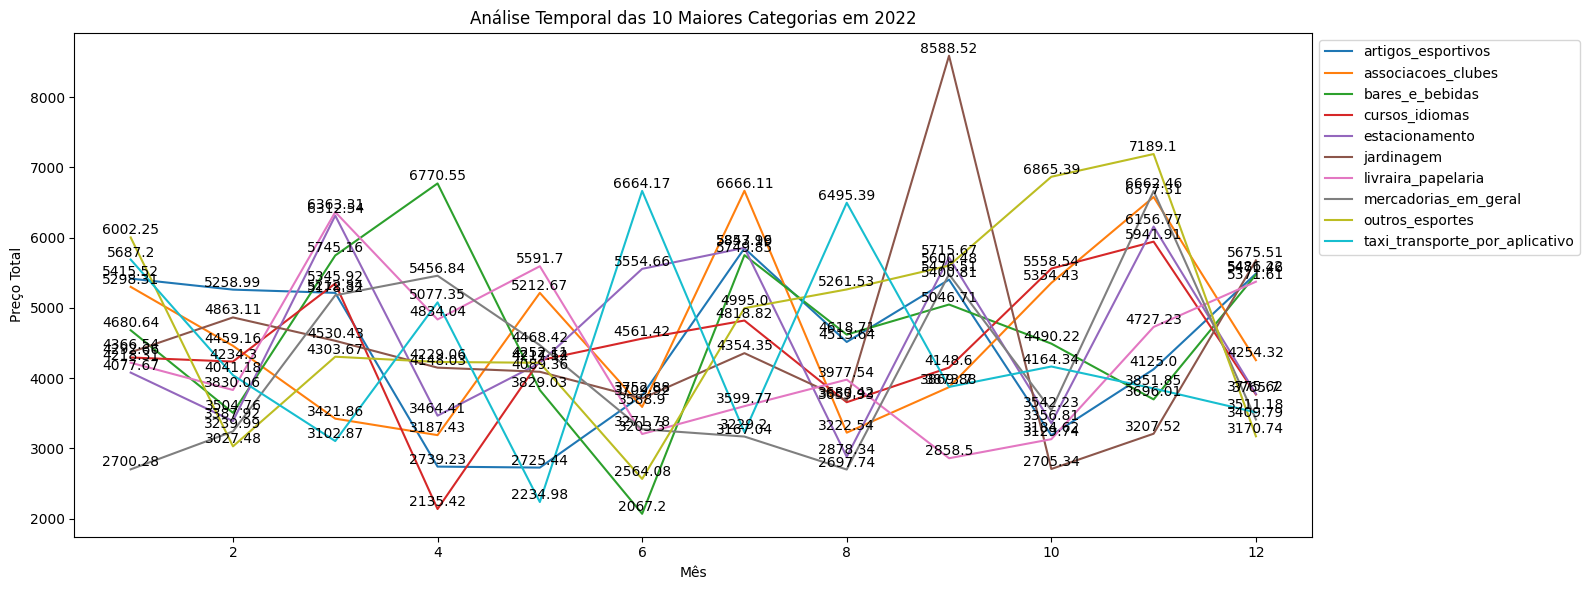

In [12]:
for year in unique_years:
    maiores_categorias_ano(year)

#### maiores_categorias_clientes(bank_client)

In [13]:
def maiores_categorias_clientes(bank_client, year):
    df_cliente = df[df['bank_clients'] == bank_client]
    
    # Identificar as 10 maiores product_category_name de produtos
    top_10_product_category_name = df_cliente['product_category_name'].value_counts().nlargest(10).index

    # Filtrar os dados para o ano específico
    df_ano = df_cliente[df_cliente['year'] == year]

    # Agrupar os dados por mês e product_category_name, calculando o price para cada product_category_name em cada mês
    monthly_category = df_ano.groupby(['month', 'product_category_name'])['price'].sum().reset_index()

    # Filtrar apenas as 10 maiores product_category_name para cada mês
    top_categories_df = pd.DataFrame()
    for month in range(1, 13):
        top_categories = monthly_category[(monthly_category['month'] == month) &
                                        (monthly_category['product_category_name'].isin(top_10_product_category_name))]
        top_categories_df = pd.concat([top_categories_df, top_categories])

    # Plotar gráfico de linhas para cada categoria com rótulos para os valores
    plt.figure(figsize=(20, 12))
    for category in top_categories_df['product_category_name'].unique():
        category_df = top_categories_df[top_categories_df['product_category_name'] == category]
        plt.plot(category_df['month'], category_df['price'], label=category)

        # Adicionar rótulos aos valores no gráfico
        for i, price in enumerate(category_df['price']):
            plt.text(category_df.iloc[i]['month'], price, str(round(price, 2)), ha='center', va='bottom')

    plt.xlabel('Mês')
    plt.ylabel('Preço Total')
    plt.title(f'Análise Temporal das 10 Maiores Categorias em {year}')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


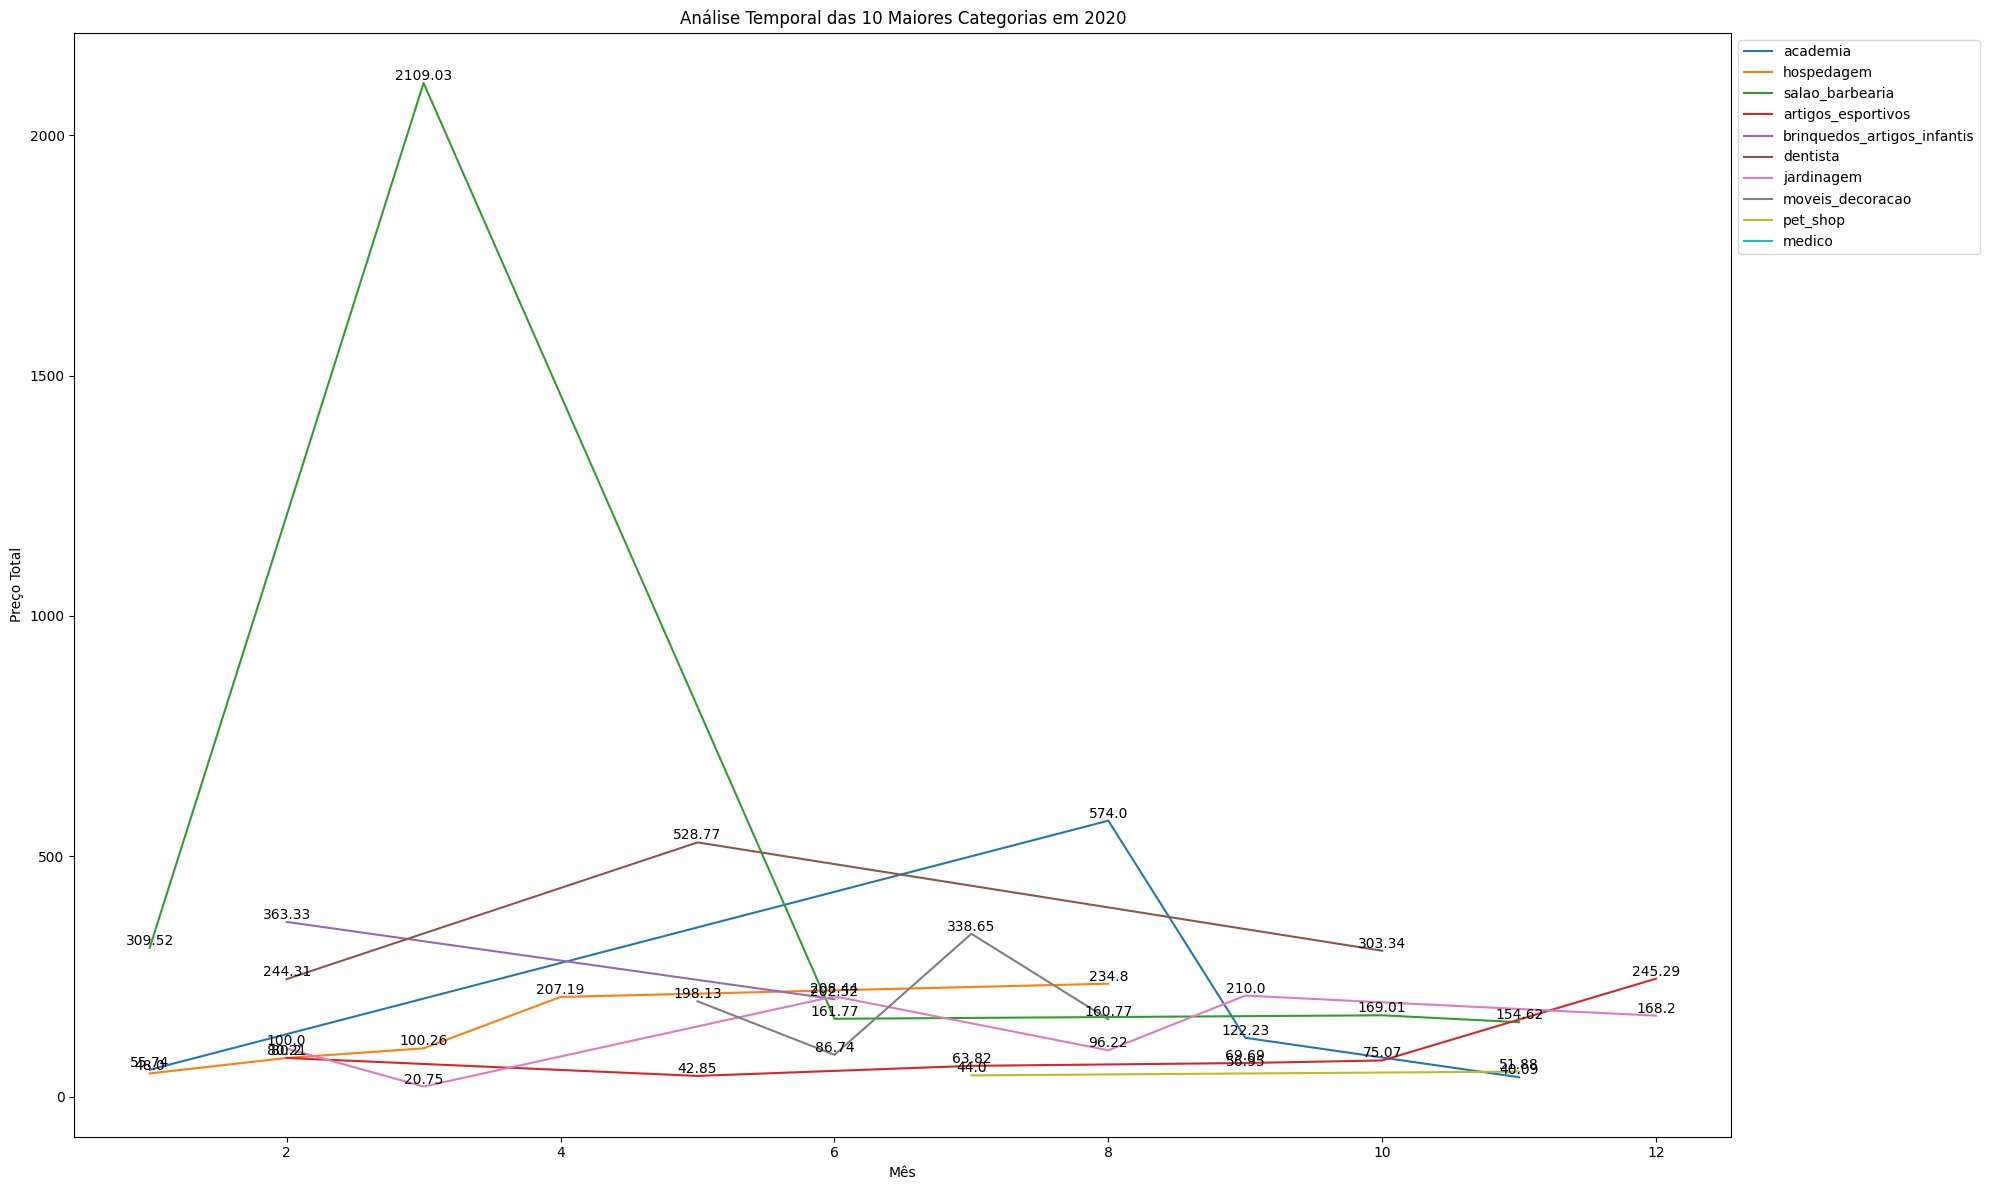

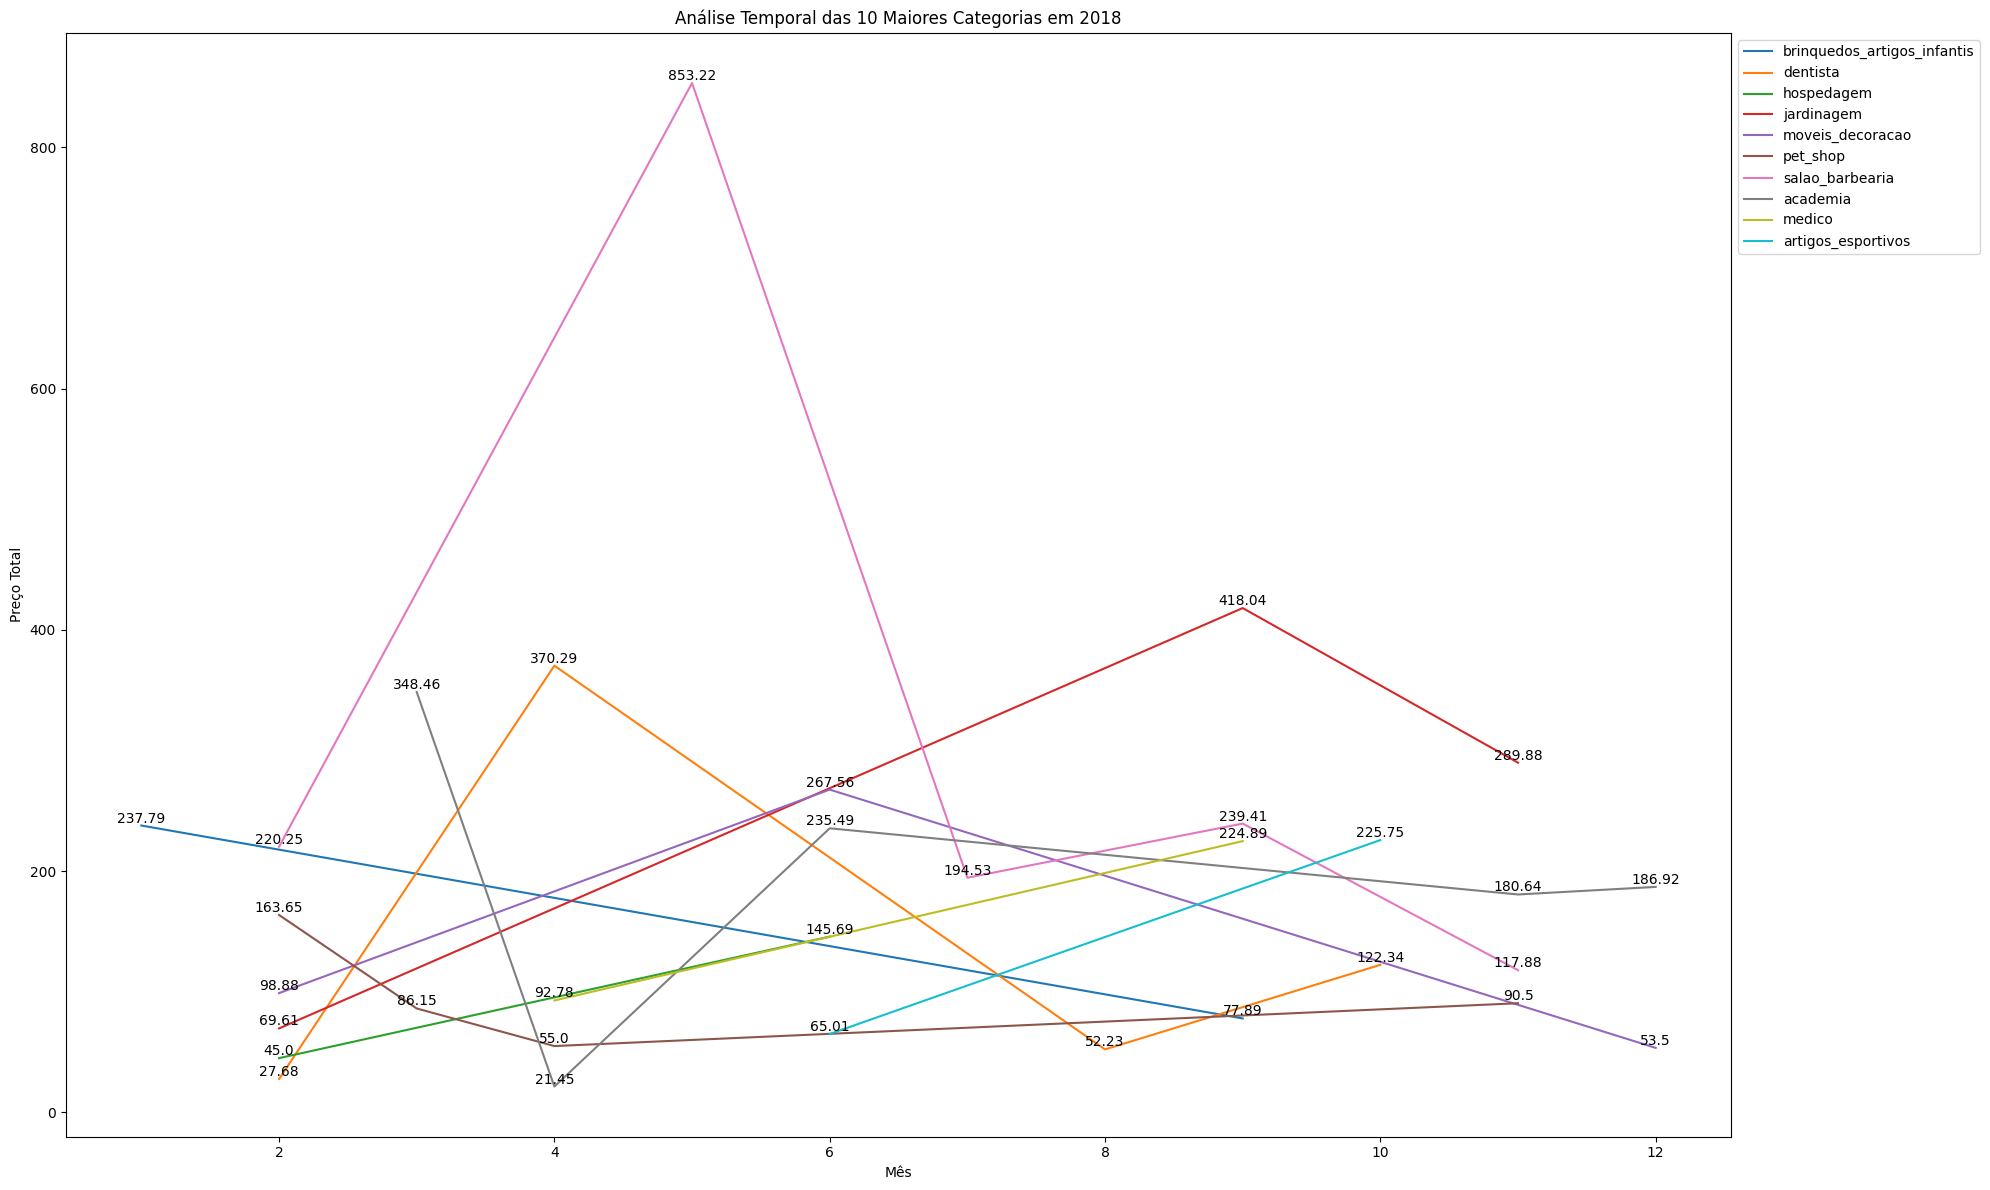

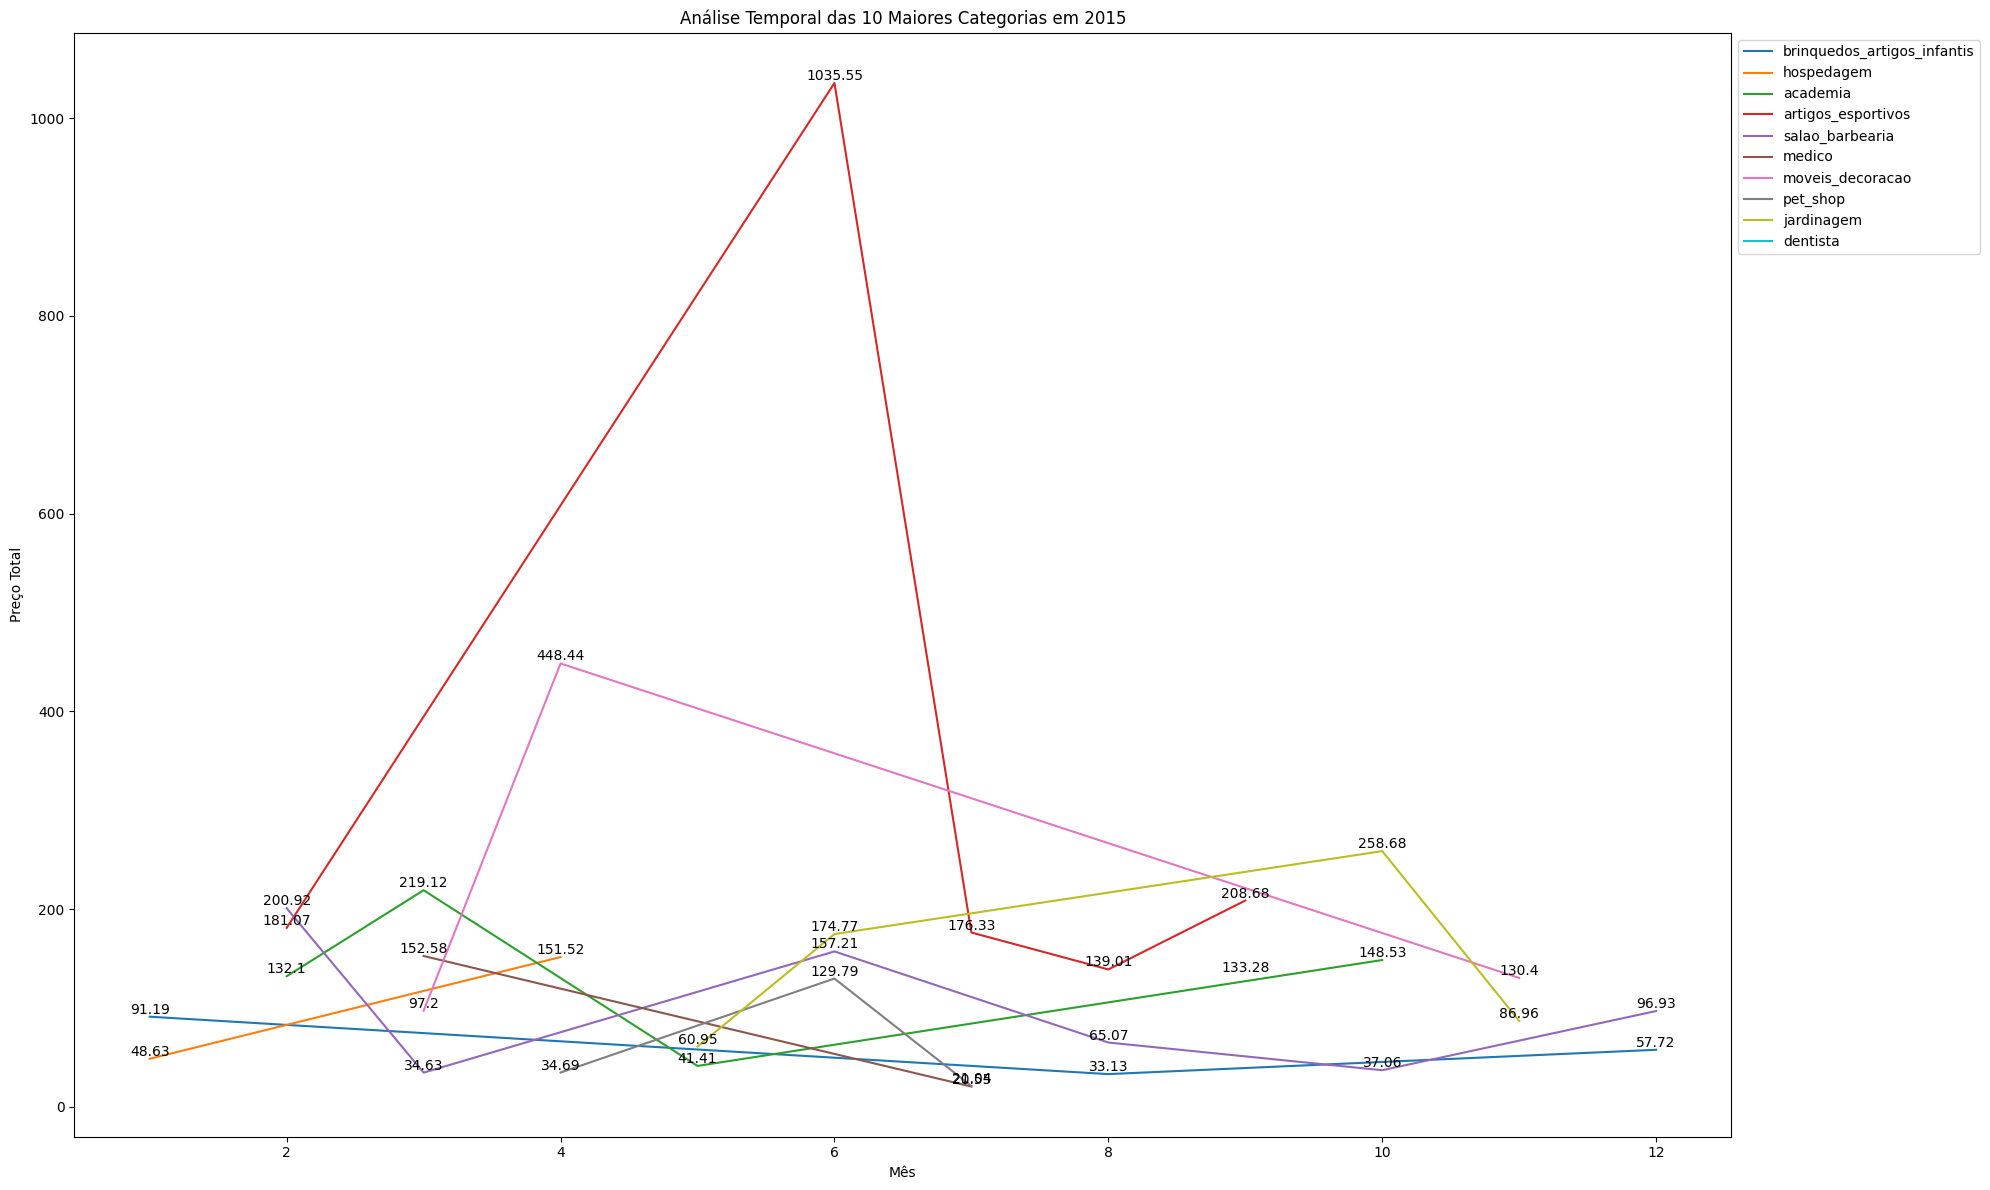

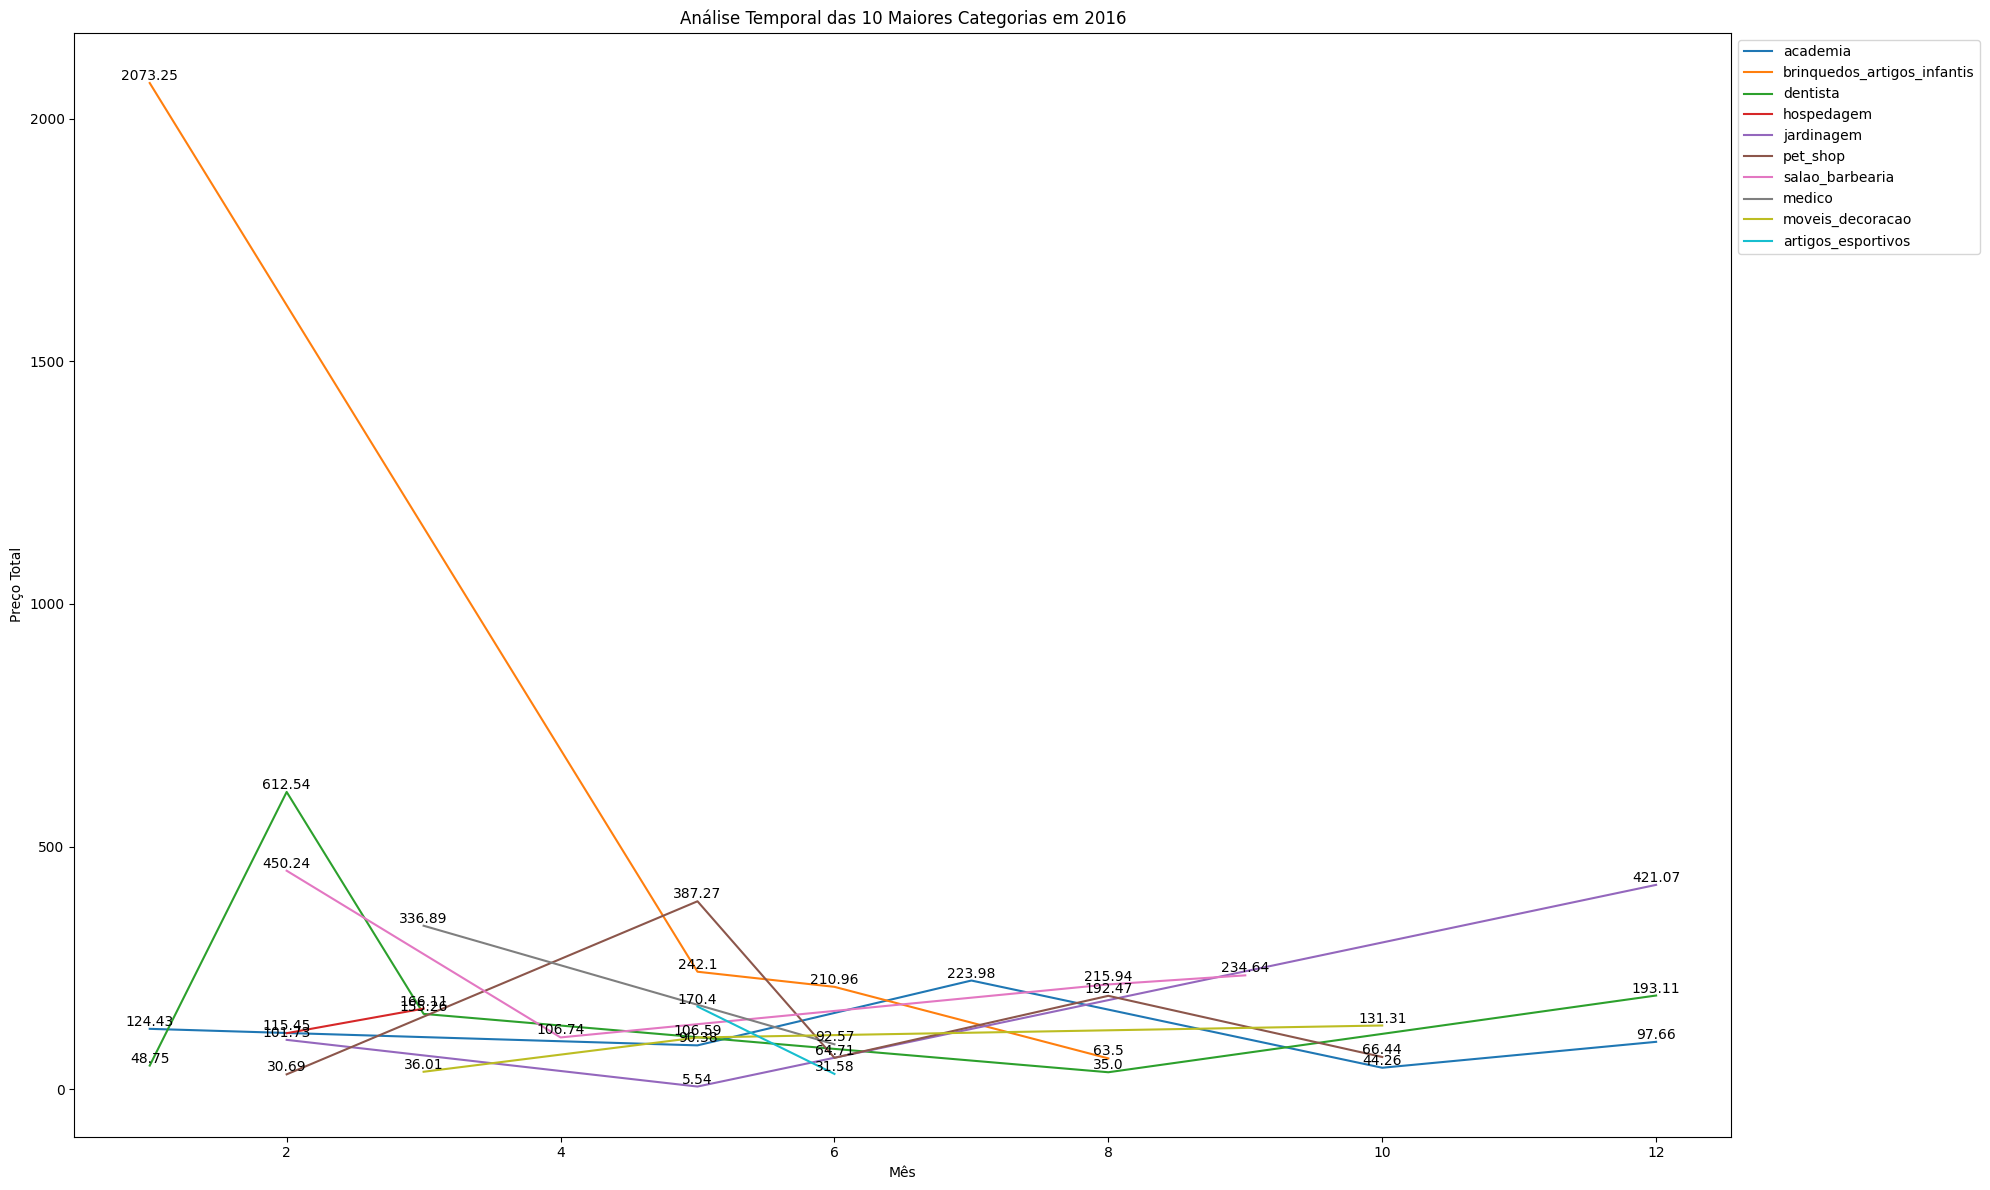

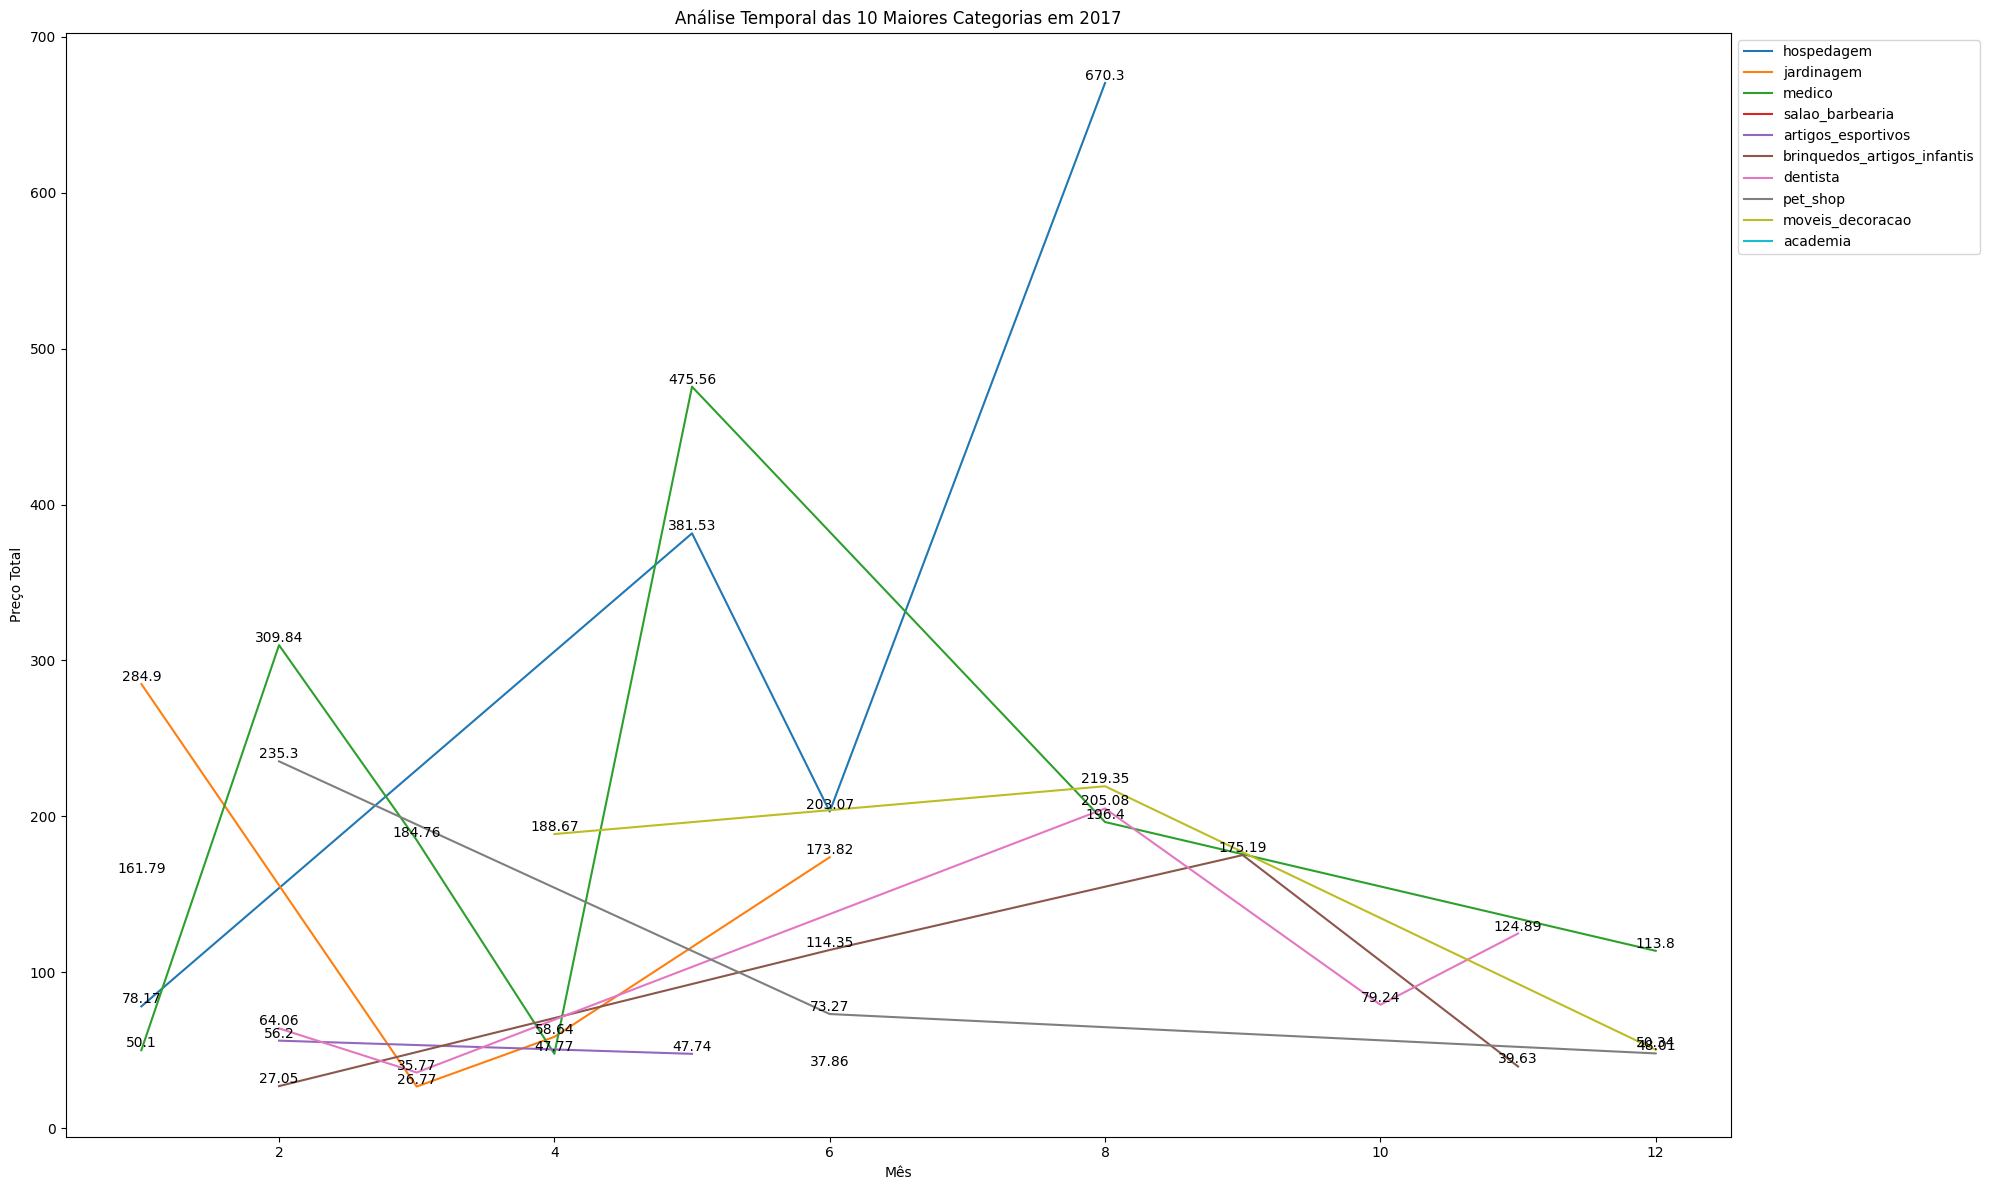

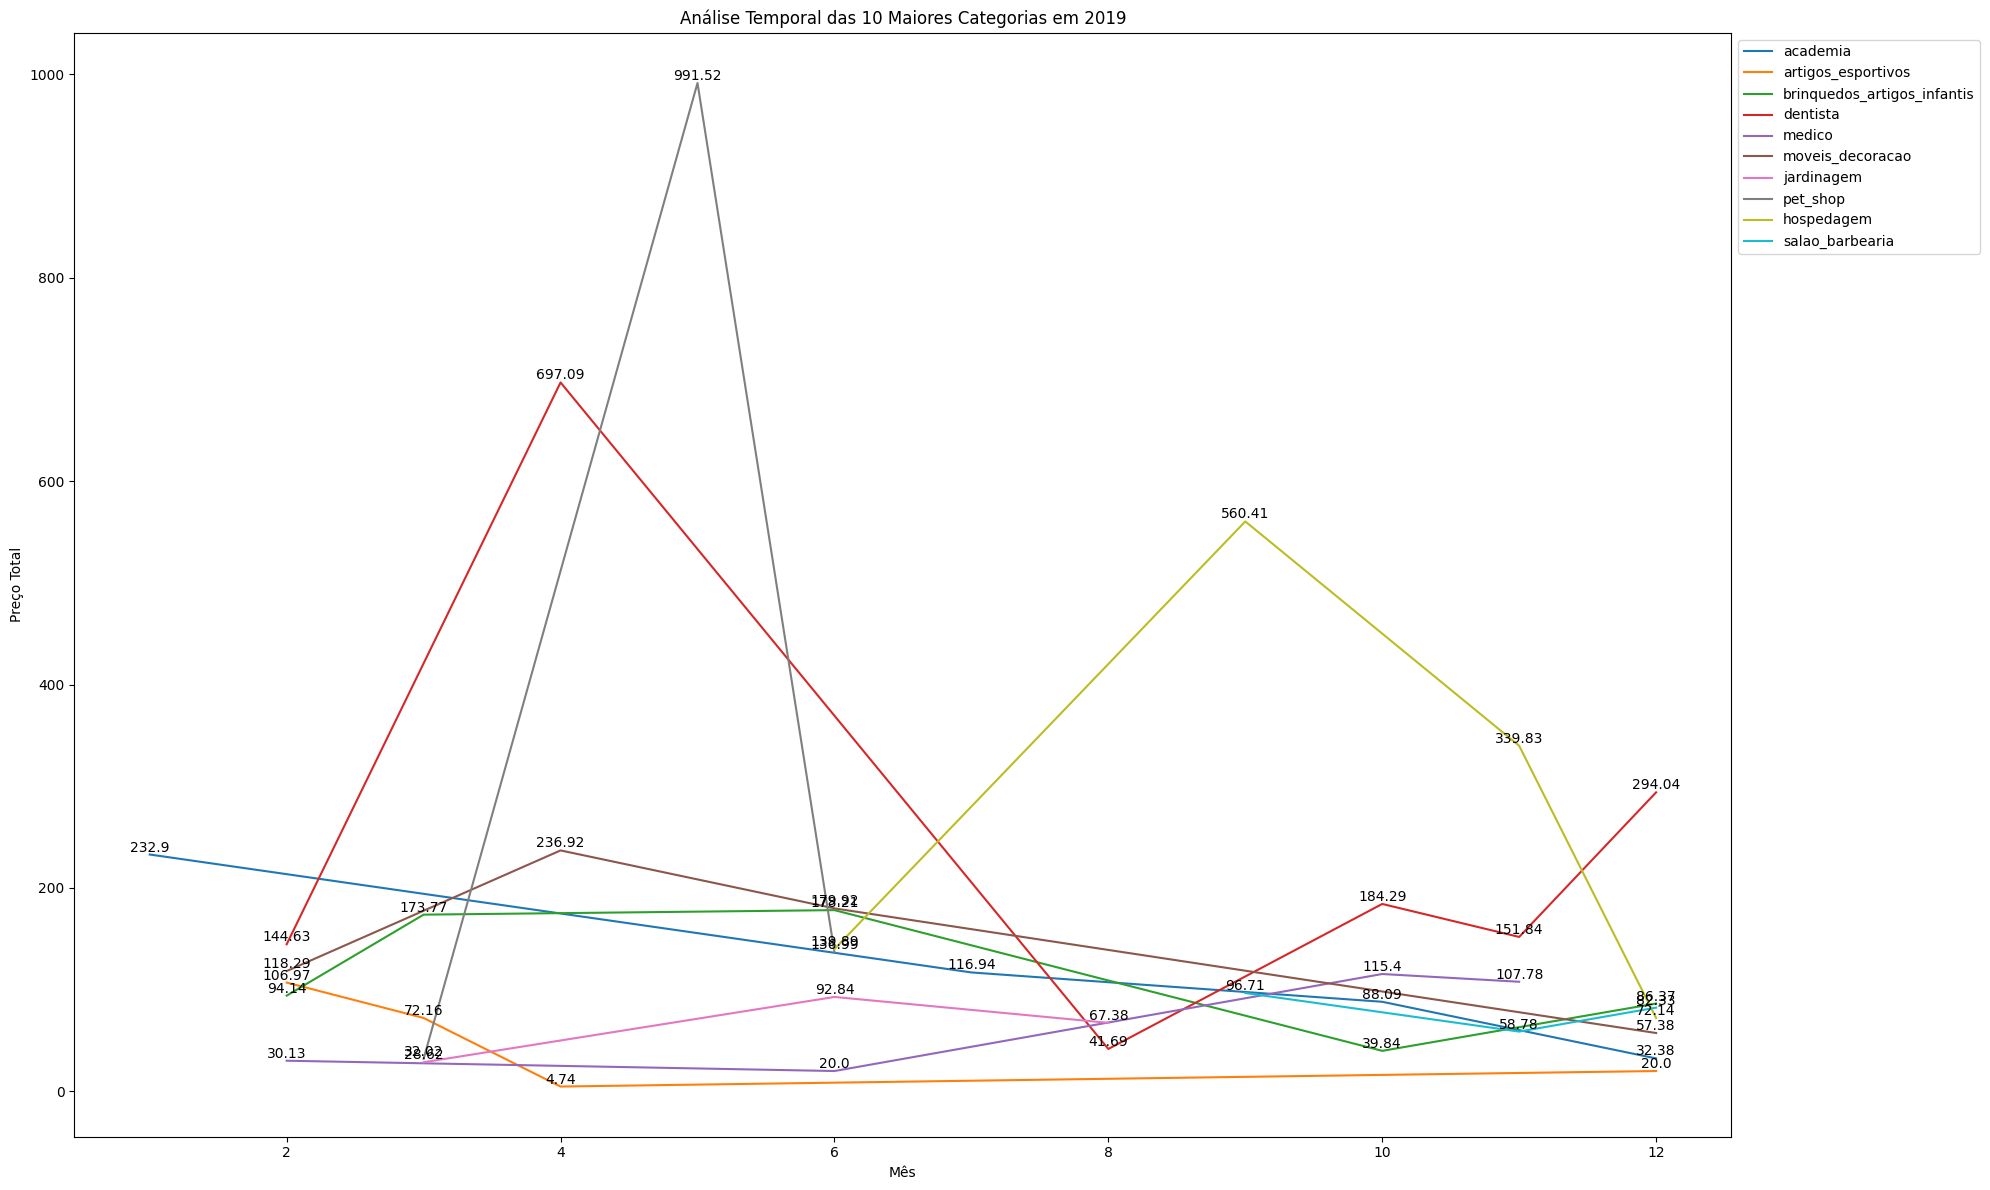

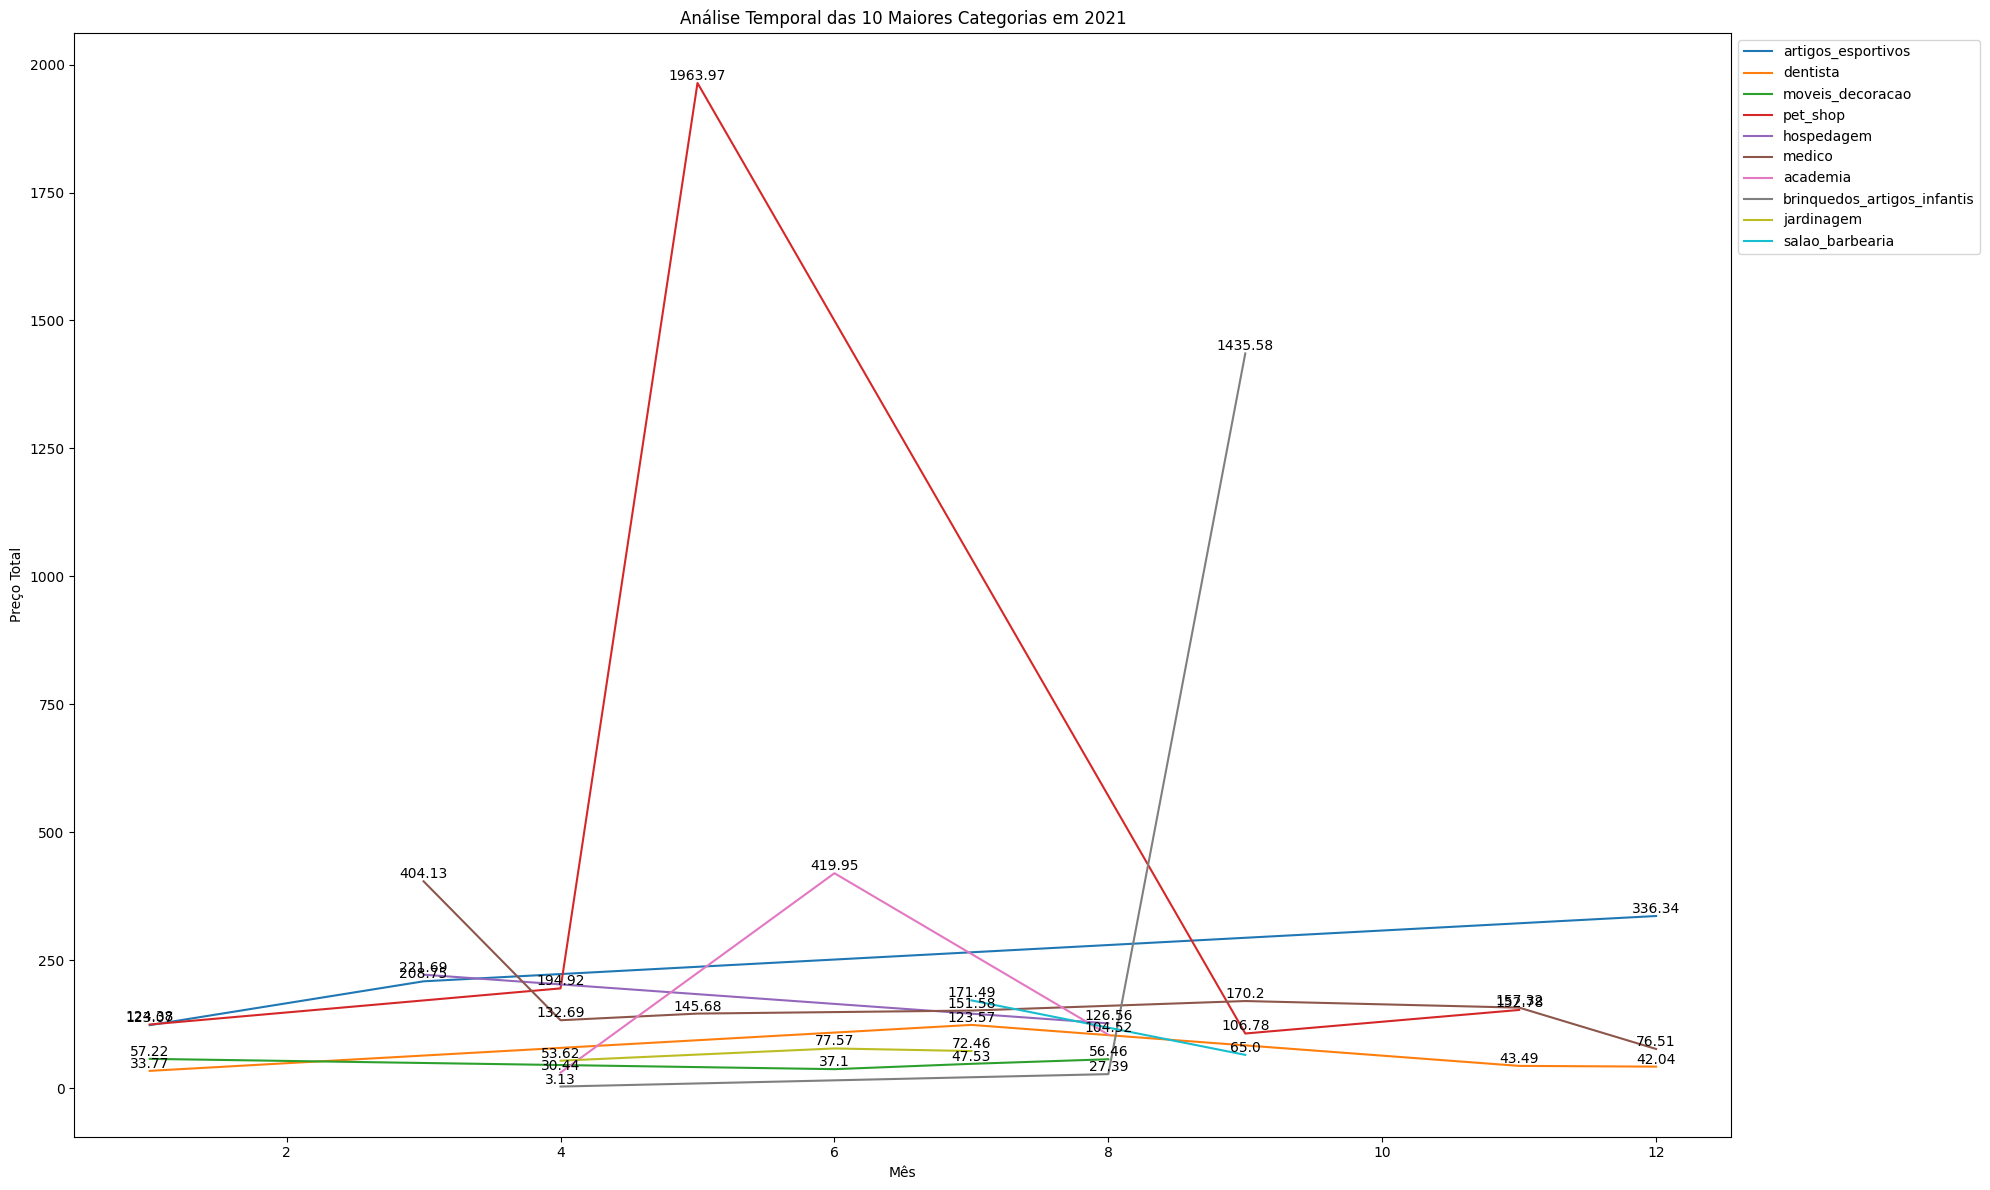

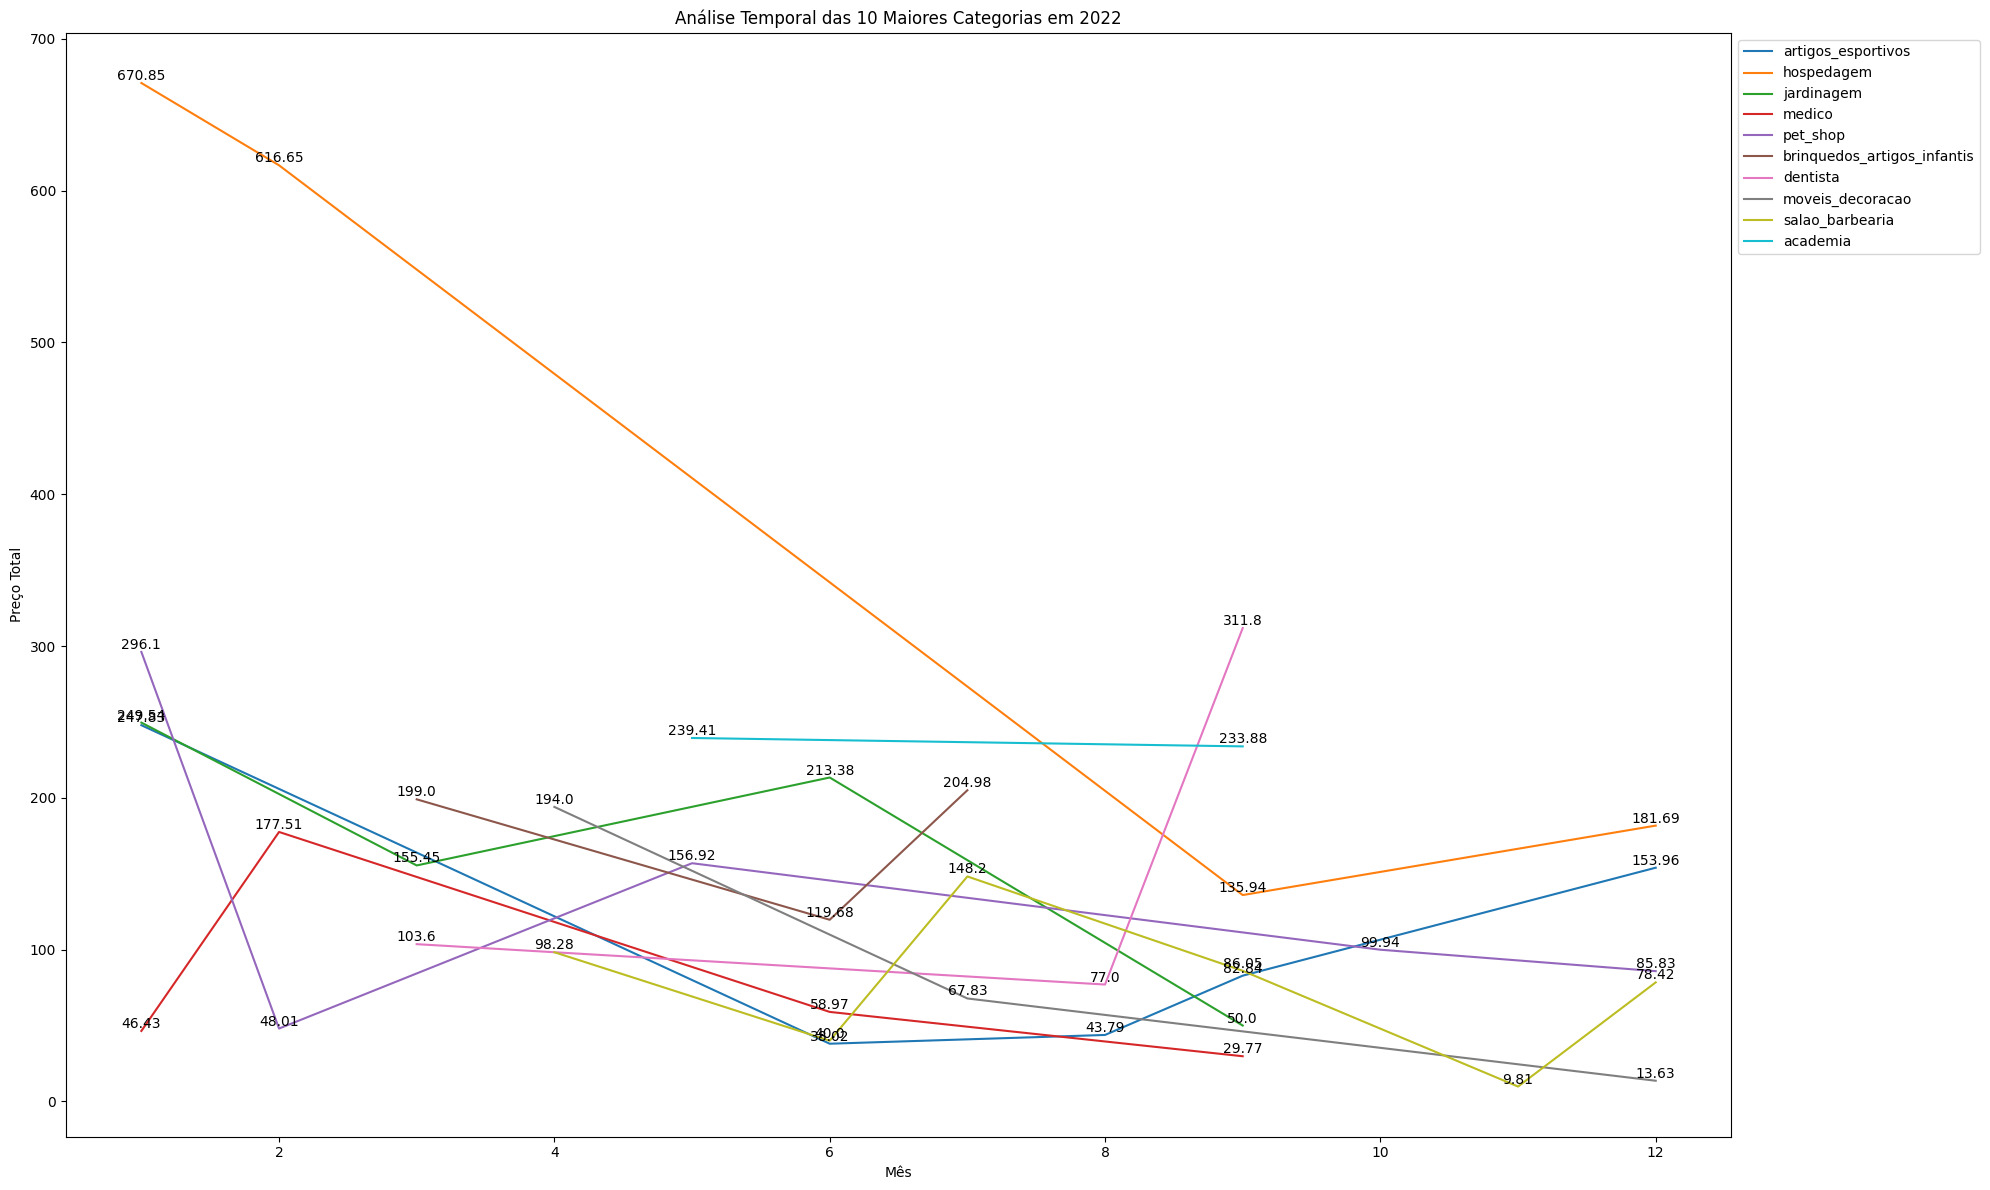

In [14]:
for year in unique_years:
    maiores_categorias_clientes('Jianming', year)

### Dados e Estatísticas

#### Distribuição dos Valores Totais ['price']

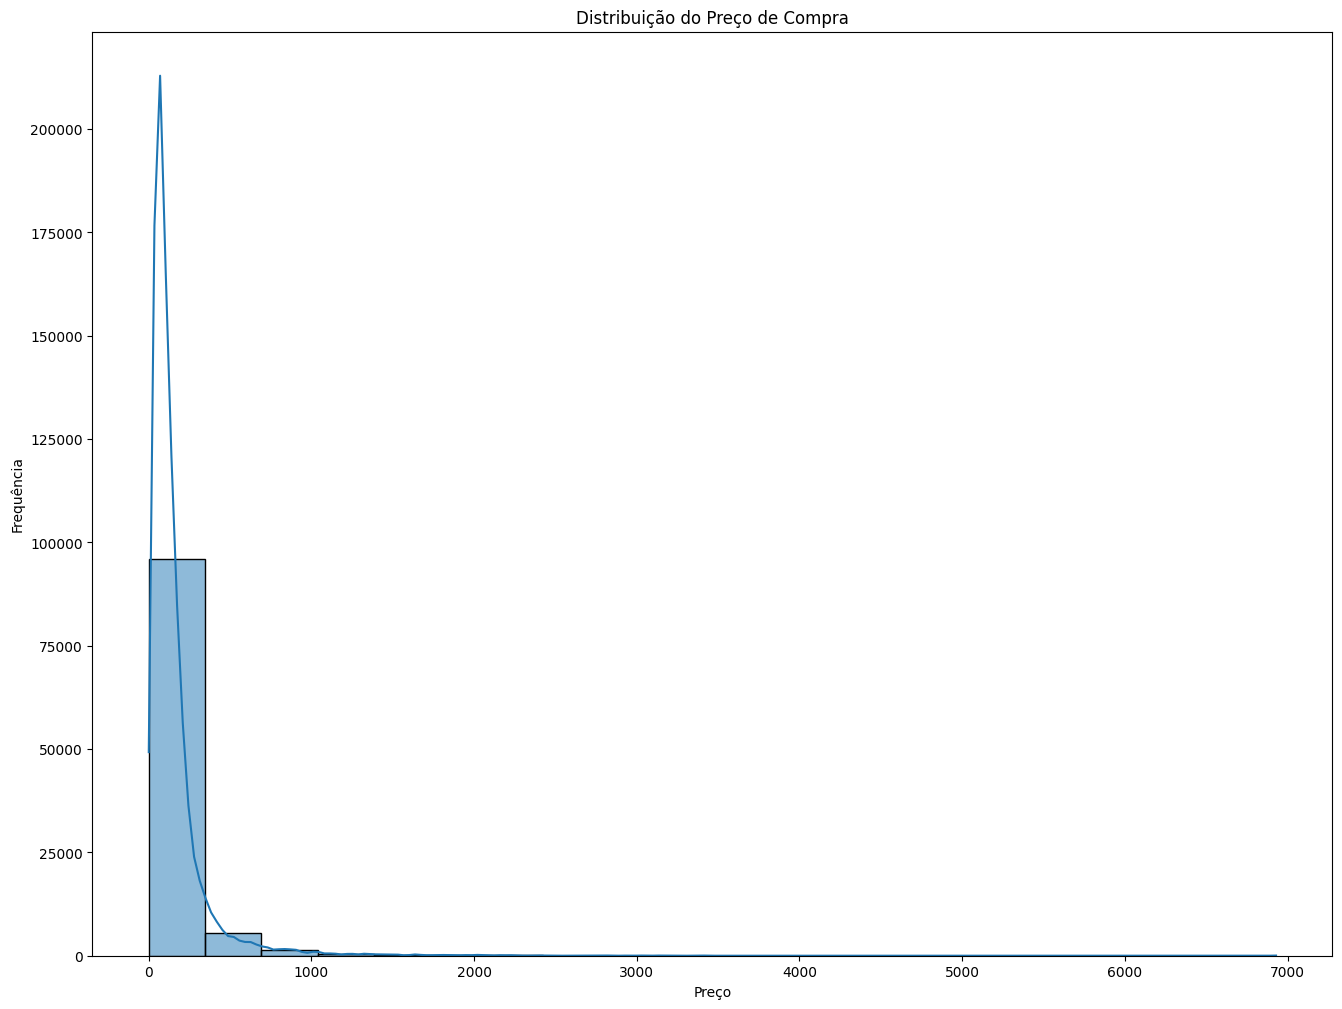

In [15]:
# Visualizar um histograma da coluna price
plt.figure(figsize=(16, 12))
sns.histplot(data=df, x='price', bins=20, kde=True)
plt.title('Distribuição do Preço de Compra')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.show()

#### Adicionando Coluna parcel_value

In [16]:
df['parcel_value'] = df['price'] / df['payment_installments']

df.head()

product_category_name   price  payment_sequential  \
0                     dentista  145.86                   3   
1  brinquedos_artigos_infantis   99.16                   1   
2       vestuario_e_acessorios  119.82                   1   
3                  combustível   50.84                   1   
4         loja_de_conveniencia   36.13                   1   

   payment_installments bank_clients  month  year  parcel_value  
0                    10         Jeff      2  2020        14.586  
1                     1        Norma      6  2018        99.160  
2                     1      Solomon      4  2015       119.820  
3                     8         Sita      8  2015         6.355  
4                     1      Richard      3  2016        36.130

#### Box Plot

##### Preço

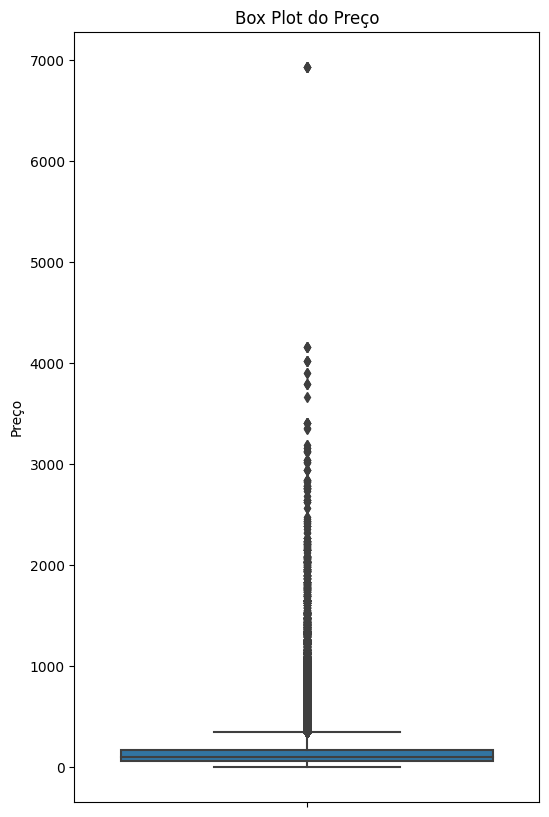

In [17]:
plt.figure(figsize=(6, 10))
sns.boxplot(data=df, y='price')
plt.title('Box Plot do Preço')
plt.ylabel('Preço')
plt.show()

##### Gastos Totais Mensais

In [18]:
# Agrupar os gastos mensais totais
df_gastos_mensais = df.groupby(['year', 'month'])['price'].sum().reset_index()

# Definir a coluna 'month' como o índice do DataFrame
df_gastos_mensais.set_index('month', inplace=True)

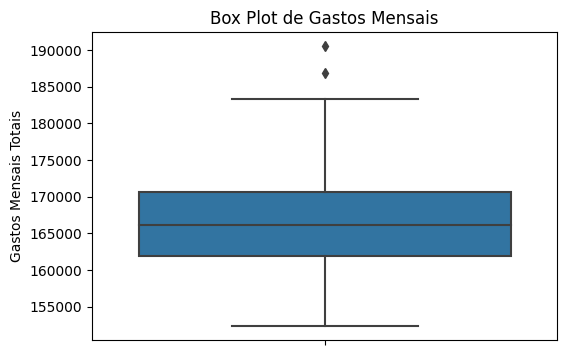

In [19]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_gastos_mensais, y='price')
plt.title('Box Plot de Gastos Mensais')
plt.ylabel('Gastos Mensais Totais')
plt.show()

##### Valor da Parcela

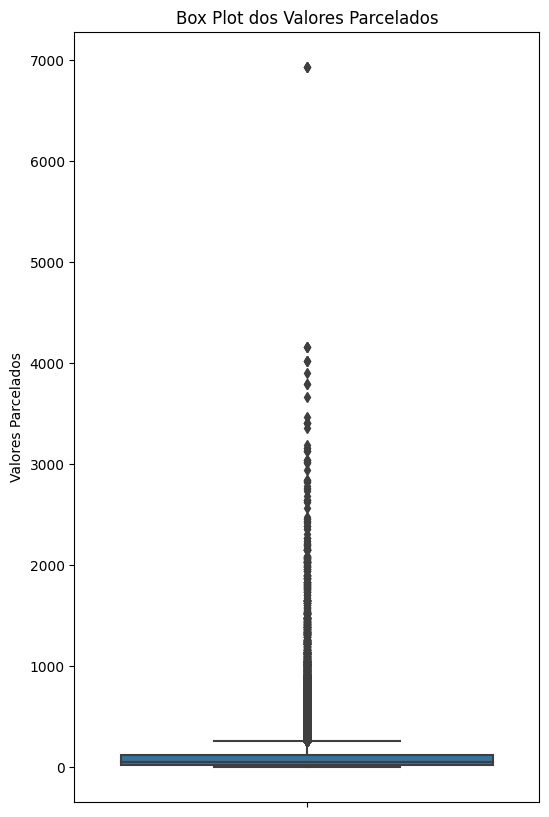

In [20]:
plt.figure(figsize=(6, 10))
sns.boxplot(data=df, y='parcel_value')
plt.title('Box Plot dos Valores Parcelados')
plt.ylabel('Valores Parcelados')
plt.show()

#### Matrix de Correlação

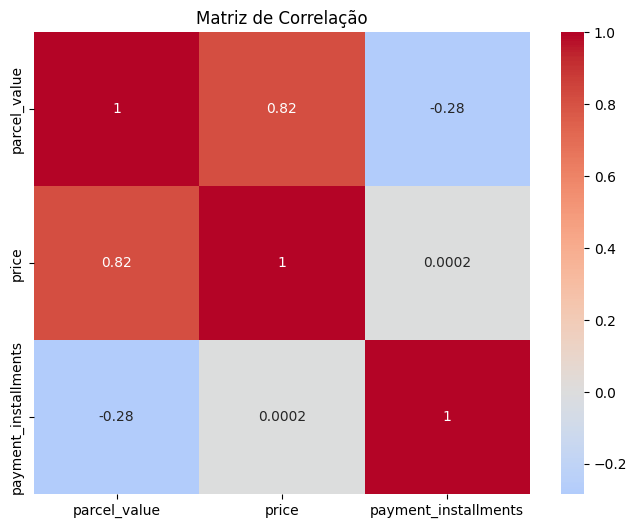

In [21]:
# Calcular a matriz de correlação
correlation_matrix = df[['parcel_value', 'price', 'payment_installments']].corr()

# Visualizar a matriz de correlação usando um mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

#### Gráfico de Dispersão entre Categoria e Preço

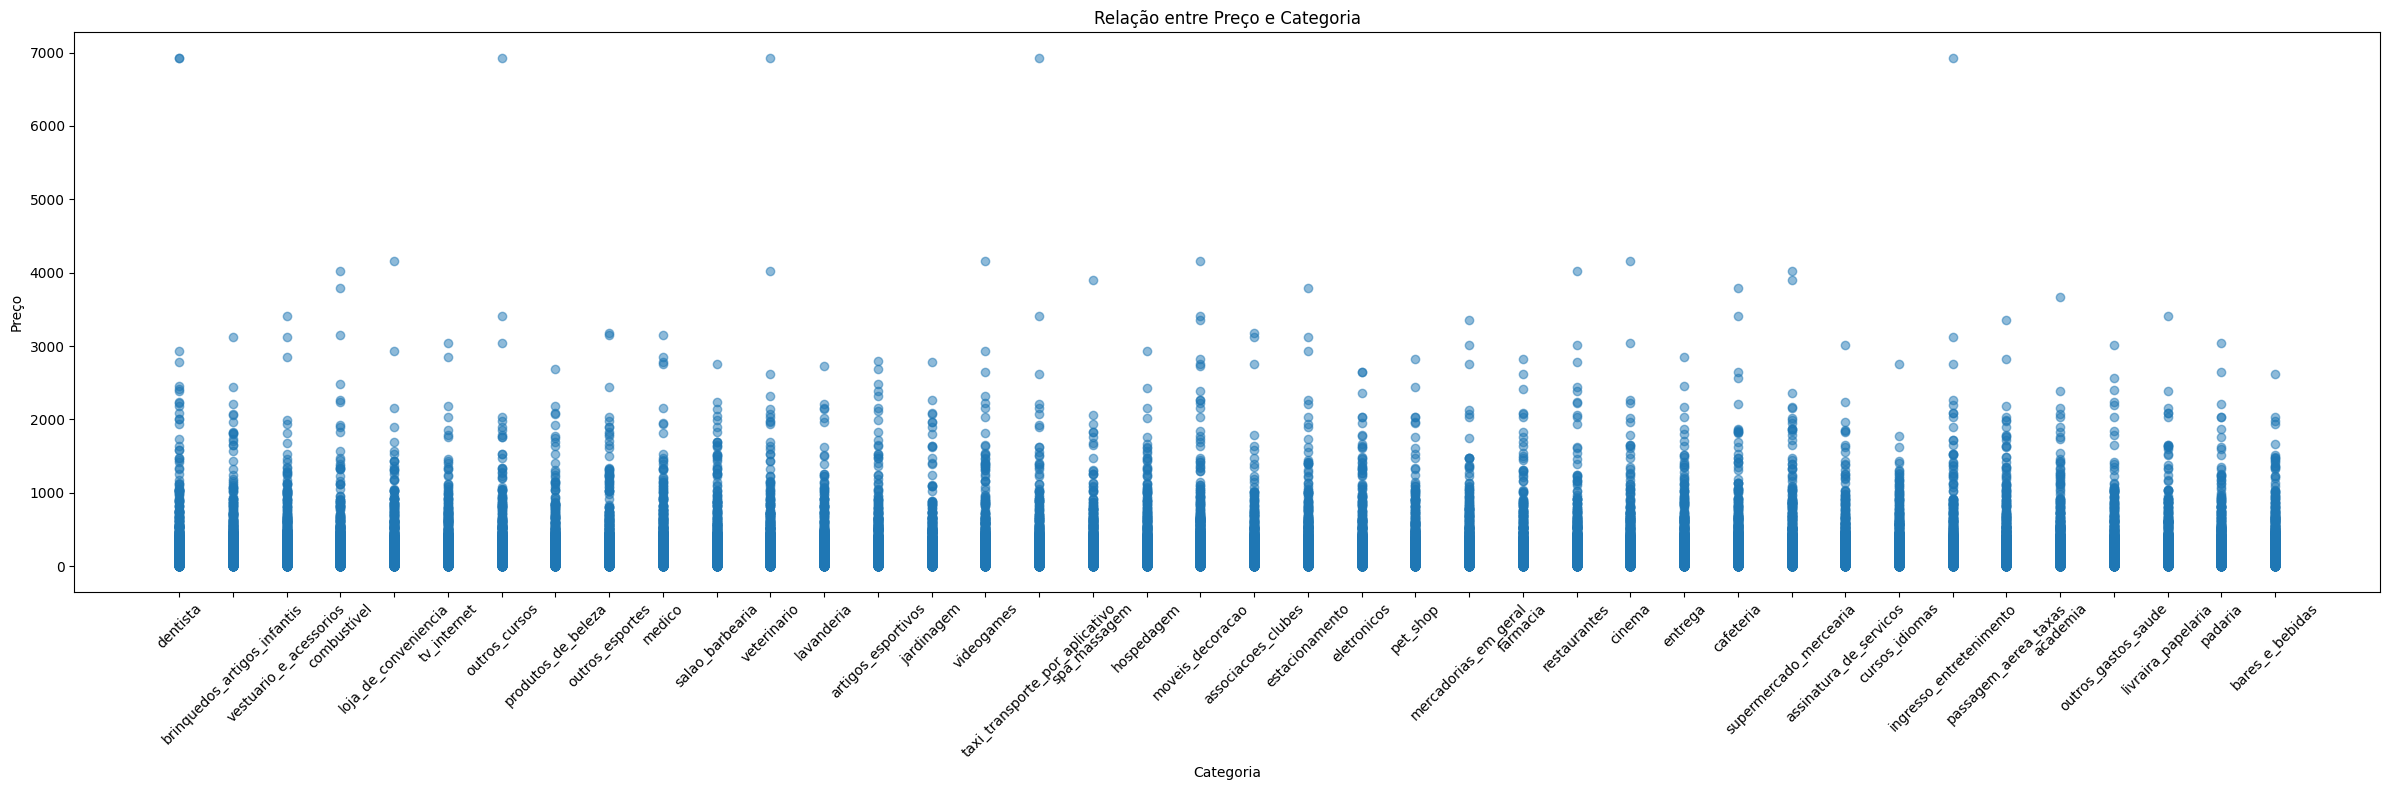

In [22]:
plt.figure(figsize=(24, 8))
plt.scatter(df['product_category_name'], df['price'], alpha=0.5)
plt.title('Relação entre Preço e Categoria')
plt.xlabel('Categoria')
plt.ylabel('Preço')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Histograma do Preço

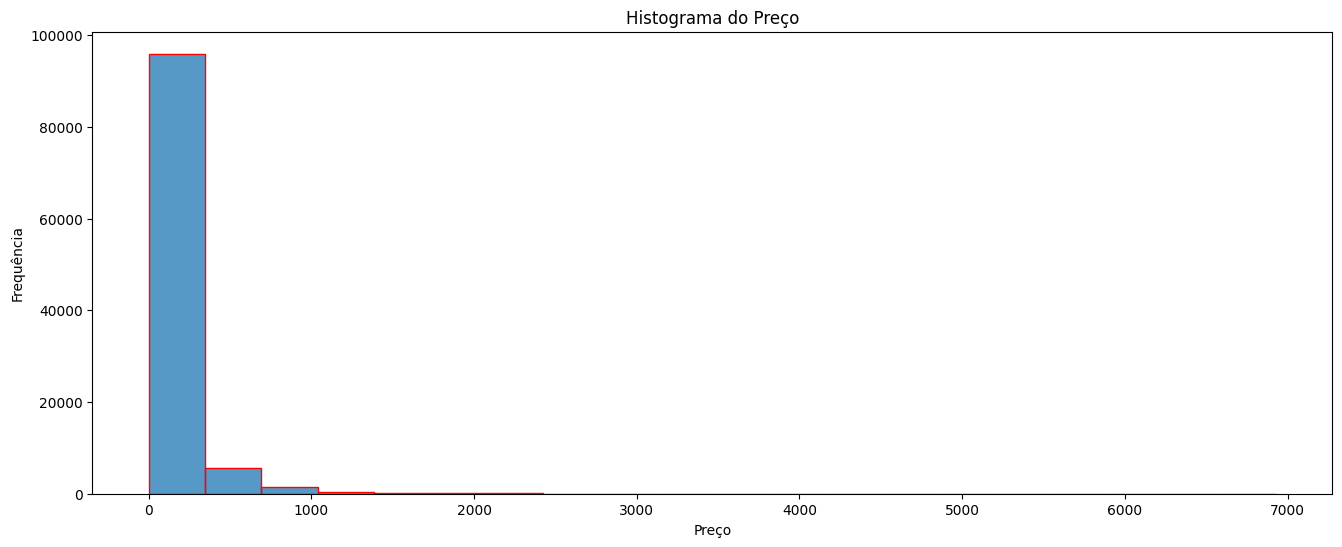

In [30]:
plt.figure(figsize=(16, 6))
sns.histplot(df['price'], bins=20, edgecolor='red')
plt.xlabel('Preço')
plt.ylabel('Frequência')
plt.title('Histograma do Preço')
plt.show()

## Treinamento do Modelo

In [24]:
df_train = df.drop(columns=['bank_clients', 'month', 'year'])

In [25]:
df_train.head()

product_category_name   price  payment_sequential  \
0                     dentista  145.86                   3   
1  brinquedos_artigos_infantis   99.16                   1   
2       vestuario_e_acessorios  119.82                   1   
3                  combustível   50.84                   1   
4         loja_de_conveniencia   36.13                   1   

   payment_installments  parcel_value  
0                    10        14.586  
1                     1        99.160  
2                     1       119.820  
3                     8         6.355  
4                     1        36.130

### Normalização da coluna Price

In [26]:
# Criar um objeto MinMaxScaler
scaler = MinMaxScaler()

# Aplicar a normalização nas colunas selecionadas
df_train['price'] = scaler.fit_transform(df_train[['price']])
# Aplicar a normalização nas colunas selecionadas
df_train['parcel_value'] = scaler.fit_transform(df_train[['parcel_value']])

df_train.head()

product_category_name     price  payment_sequential  \
0                     dentista  0.021050                   3   
1  brinquedos_artigos_infantis  0.014310                   1   
2       vestuario_e_acessorios  0.017292                   1   
3                  combustível  0.007337                   1   
4         loja_de_conveniencia  0.005214                   1   

   payment_installments  parcel_value  
0                    10      0.002105  
1                     1      0.014310  
2                     1      0.017292  
3                     8      0.000917  
4                     1      0.005214

#### Divisão dos dados em treinamento e teste

In [31]:
df_train = pd.get_dummies(df_train, columns=['product_category_name'])

In [32]:

# Divisão dos dados em treinamento e teste
X = df_train.drop(columns=['price'])
y = df_train['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)  
X_pca = pca.fit_transform(X_scaled)

# Divisão dos dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

### Modelo Linear Regression

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

# Avaliação do modelo
y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE: {rmse}')

RMSE: 0.026363415452223732


### KMeans

c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


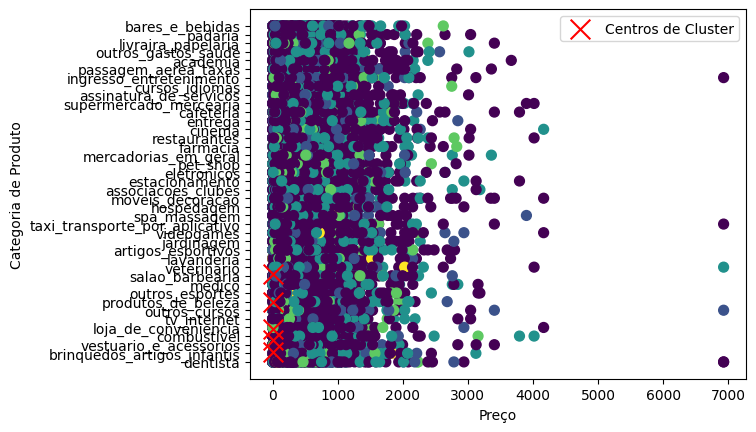

In [ ]:
from sklearn.cluster import KMeans

# Treinar o modelo K-Means para clustering
kmeans_model = KMeans(n_clusters=5, random_state=42)
kmeans_model.fit(X)  # Suponha que X seja o seu conjunto de dados

# Adicionar as etiquetas de cluster de volta aos seus dados
cluster_labels = kmeans_model.labels_

# Visualizar os cluster centers
cluster_centers = kmeans_model.cluster_centers_

# Visualização dos dados originais
plt.scatter(df['price'], df['product_category_name'], c=cluster_labels, cmap='viridis', s=50)

# Visualização dos centros dos clusters
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='red', marker='x', s=200, label='Centros de Cluster')

plt.xlabel('Preço')
plt.ylabel('Categoria de Produto')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score

# cluster_labels são as etiquetas de cluster geradas pelo K-Means
silhouette_avg = silhouette_score(X, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

# cluster_centers são os centros dos clusters gerados pelo K-Means
db_index = davies_bouldin_score(X, cluster_labels)
print(f'Davies-Bouldin Index: {db_index}')


Silhouette Score: 0.4236140234122311
Davies-Bouldin Index: 0.8274863796489035


### KNeighborsRegressor

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

# Treinar o modelo KNN para regressão
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Avaliação do modelo
y_pred_knn = knn_model.predict(X_test)
rmse_knn = mean_squared_error(y_test, y_pred_knn, squared=False)
print(f'KNN RMSE: {rmse_knn}')

KNN RMSE: 0.01695364594724707


### Previsão Temporal

#### Gastos Totais

In [ ]:
# Agrupe os dados por ano e mês e calcule o gasto total de cada mês
df_grouped = df.groupby(['year', 'month'])['price'].sum().reset_index()

# Crie um novo DataFrame para armazenar os gastos totais
df_total_expenses = df_grouped.rename(columns={'price': 'total_expenses'})

##### ExponentialSmoothing

In [ ]:
# Ajuste o modelo ESS
model_ess = ExponentialSmoothing(df_total_expenses['total_expenses'], seasonal='add', seasonal_periods=12)
model_ess_fit = model_ess.fit()

# Faça previsões com o modelo ESS
predictions_ess = model_ess_fit.forecast(steps=12)  # 12 meses no futuro

# Calcule o MSE
mse = mean_squared_error(df_total_expenses['total_expenses'][-12:], predictions_ess)

# Print do MSE
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 71821571.68799095


c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


##### ARIMA

In [ ]:
p, d, q = 1, 1, 1

# Ajuste o modelo ARIMA
model_arima = ARIMA(df_total_expenses['total_expenses'], order=(p, d, q))  # Substitua p, d e q pelos valores adequados
model_arima_fit = model_arima.fit()

# Faça previsões com o modelo ARIMA
predictions_arima = model_arima_fit.forecast(steps=12)  # 12 meses no futuro

# Calcule o MSE
mse = mean_squared_error(df_total_expenses['total_expenses'][-12:], predictions_arima)

# Print do MSE
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 223605992.76303694


##### LSTM

In [ ]:
# Normalização dos dados
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df_total_expenses['total_expenses'].values.reshape(-1, 1))

# Divisão dos dados em séries temporais
X, y = [], []
look_back = 12  # Use 12 meses como janela
for i in range(len(scaled_data) - look_back):
    X.append(scaled_data[i:i+look_back, 0])
    y.append(scaled_data[i+look_back, 0])

X, y = np.array(X), np.array(y)

# Criação do modelo LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Treinamento do modelo LSTM
model_lstm.fit(X, y, epochs=100, batch_size=1)

# Faça previsões com o modelo LSTM
future_months = 12  # 8 meses no futuro
future_x = scaled_data[-look_back:, 0]
future_predictions = []



for i in range(future_months):
    prediction = model_lstm.predict(future_x[-look_back:].reshape(1, look_back, 1))
    future_x = np.append(future_x, prediction[0])
    future_predictions.append(scaler.inverse_transform(prediction)[0][0])

# Calcule o MSE
mse = mean_squared_error(df_total_expenses['total_expenses'][-12:], future_predictions)

# Print do MSE
print(f"Mean Squared Error (MSE): {mse}")

Epoch 1/100
84/84 [==============================] - 2s 4ms/step - loss: 0.0547
Epoch 2/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0446
Epoch 3/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0460
Epoch 4/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0457
Epoch 5/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0457
Epoch 6/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0461
Epoch 7/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0454
Epoch 8/100
84/84 [==============================] - 0s 3ms/step - loss: 0.0496
Epoch 9/100
84/84 [==============================] - 0s 3ms/step - loss: 0.0457
Epoch 10/100
84/84 [==============================] - 0s 3ms/step - loss: 0.0447
Epoch 11/100
84/84 [==============================] - 0s 4ms/step - loss: 0.0456
Epoch 12/100
84/84 [==============================] - 0s 3ms/step - loss: 0.0449
Epoch 13/100
84/84 [=================

##### Plot dos Dados

Plot 1

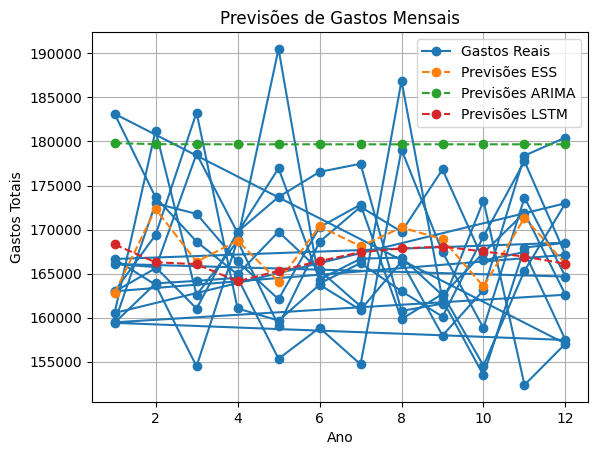

In [ ]:
# Plote os dados reais
plt.plot(df_total_expenses['month'], df_total_expenses['total_expenses'], label='Gastos Reais', marker='o')

# Plote as previsões para cada modelo (ESS, ARIMA, LSTM)
plt.plot(df_total_expenses['month'].unique(), predictions_ess, label='Previsões ESS', linestyle='--', marker='o')
plt.plot(df_total_expenses['month'].unique(), predictions_arima, label='Previsões ARIMA', linestyle='--', marker='o')
plt.plot(df_total_expenses['month'].unique(), future_predictions, label='Previsões LSTM', linestyle='--', marker='o')

plt.xlabel('Ano')
plt.ylabel('Gastos Totais')
plt.legend()
plt.title('Previsões de Gastos Mensais')
plt.grid(True)
plt.show()

Plot 2

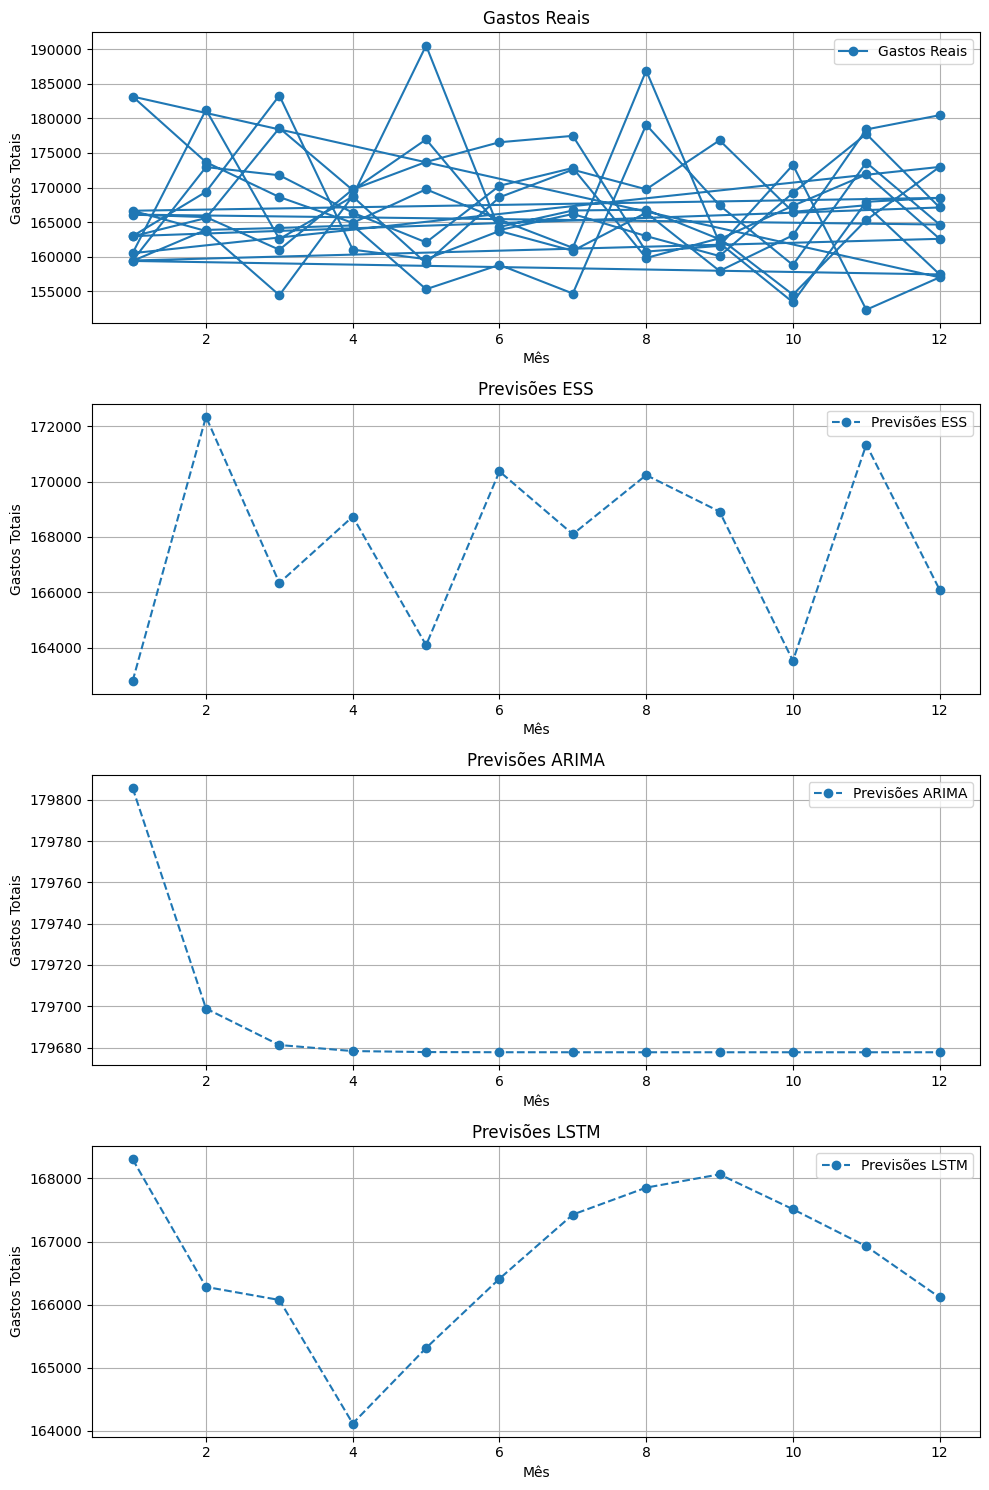

In [ ]:
# Plote os dados reais
fig, axs = plt.subplots(4, 1, figsize=(10, 15))  # Cria 3 subplots empilhados verticalmente

# Subplot 1: Gastos Reais
axs[0].plot(df_total_expenses['month'], df_total_expenses['total_expenses'], label='Gastos Reais', marker='o')
axs[0].set_xlabel('Mês')
axs[0].set_ylabel('Gastos Totais')
axs[0].set_title('Gastos Reais')
axs[0].grid(True)
axs[0].legend()

# Subplot 2: Previsões ESS
axs[1].plot(df_total_expenses['month'].unique(), predictions_ess, label='Previsões ESS', linestyle='--', marker='o')
axs[1].set_xlabel('Mês')
axs[1].set_ylabel('Gastos Totais')
axs[1].set_title('Previsões ESS')
axs[1].grid(True)
axs[1].legend()

# Subplot 3: Previsões ARIMA
axs[2].plot(df_total_expenses['month'].unique(), predictions_arima, label='Previsões ARIMA', linestyle='--', marker='o')
axs[2].set_xlabel('Mês')
axs[2].set_ylabel('Gastos Totais')
axs[2].set_title('Previsões ARIMA')
axs[2].grid(True)
axs[2].legend()

# Subplot 4: Previsões ARIMA
axs[3].plot(df_total_expenses['month'].unique(), future_predictions, label='Previsões LSTM', linestyle='--', marker='o')
axs[3].set_xlabel('Mês')
axs[3].set_ylabel('Gastos Totais')
axs[3].set_title('Previsões LSTM')
axs[3].grid(True)
axs[3].legend()

plt.tight_layout()  # Garante que os subplots não se sobreponham
plt.show()

#### Gastos por Categoria

In [ ]:
# Criar um novo DataFrame para armazenar a soma do valor total por categoria, mês e ano
df_soma_por_categoria = df.groupby(['year', 'month', 'product_category_name'])['price'].sum().reset_index()

df_soma_por_categoria.head()

year  month   product_category_name    price
0  2015      1                academia  3704.27
1  2015      1      artigos_esportivos  2978.16
2  2015      1  assinatura_de_servicos  2382.34
3  2015      1      associacoes_clubes  4605.07
4  2015      1         bares_e_bebidas  4344.52

In [ ]:
categorias = df_soma_por_categoria['product_category_name'].value_counts().nlargest(10).index

##### Modelo SimpleExpSmoothing

In [ ]:
# Função para ajustar e fazer previsões para uma categoria específica
from statsmodels.tools.eval_measures import rmse
def prever_categoria(categoria, df):
    train_size = int(len(df) * 0.8)
    train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]
    
    # Ajustar um modelo de suavização exponencial simples (SES)
    ses_model = SimpleExpSmoothing(train_data['price'])
    ses_fit = ses_model.fit()
    
    # Fazer previsões para o conjunto de teste
    predicted_ses = ses_fit.forecast(len(test_data))
    
    # Calcular a raiz do erro quadrático médio (RMSE) para avaliar a qualidade da previsão
    rmse_ses = rmse(test_data['price'], predicted_ses)    
    
    print(f'Previsão de Gastos para a Categoria "{categoria}" (RMSE={rmse_ses:.2f})')
    # Plotar os resultados
    

In [ ]:
# Iterar por todas as categorias e fazer previsões
for categoria in categorias:
    df_categoria = df_soma_por_categoria[df_soma_por_categoria['product_category_name'] == categoria]
    prever_categoria(categoria, df_categoria)

##### Modelo ARIMA

In [ ]:
#Função para ajustar e fazer previsões ARIMA para uma categoria específica
def prever_arima(categoria, df):
    train_size = int(len(df) * 0.8)
    train_data, test_data = df.iloc[:train_size], df.iloc[train_size:]
    
    # Ajustar um modelo ARIMA
    p, d, q = 1, 1, 1  # Ordem dos termos AR, diferenciação e MA (você pode ajustar esses valores)
    arima_model = ARIMA(train_data['price'], order=(p, d, q))
    arima_fit = arima_model.fit()
    
    # Fazer previsões para o conjunto de teste
    predicted_arima = arima_fit.forecast(steps=len(test_data))
    
    # Calcular o RMSE para avaliar a qualidade da previsão
    rmse_arima = rmse(test_data['price'], predicted_arima)

    print(f'Previsão de Gastos para a Categoria "{categoria}" usando ARIMA (RMSE={rmse_arima:.2f}) {predicted_arima}')
    
for categoria in categorias:
    df_categoria = df_soma_por_categoria[df_soma_por_categoria['product_category_name'] == categoria]
    prever_arima(categoria, df_categoria)


c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\beaso\AppData\Local

Previsão de Gastos para a Categoria "academia" usando ARIMA (RMSE=1665.04) 76    4107.329551
77    4150.100584
78    4147.532520
79    4147.686712
80    4147.677454
81    4147.678010
82    4147.677977
83    4147.677979
84    4147.677979
85    4147.677979
86    4147.677979
87    4147.677979
88    4147.677979
89    4147.677979
90    4147.677979
91    4147.677979
92    4147.677979
93    4147.677979
94    4147.677979
95    4147.677979
Name: predicted_mean, dtype: float64
Previsão de Gastos para a Categoria "artigos_esportivos" usando ARIMA (RMSE=1020.46) 76    4129.566441
77    4230.980544
78    4251.934205
79    4256.263543
80    4257.158048
81    4257.342867
82    4257.381053
83    4257.388943
84    4257.390573
85    4257.390910
86    4257.390979
87    4257.390993
88    4257.390996
89    4257.390997
90    4257.390997
91    4257.390997
92    4257.390997
93    4257.390997
94    4257.390997
95    4257.390997
Name: predicted_mean, dtype: float64
Previsão de Gastos para a Categoria "mercadori

c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

Previsão de Gastos para a Categoria "moveis_decoracao" usando ARIMA (RMSE=1347.93) 76    4652.548886
77    4651.293304
78    4651.297149
79    4651.297137
80    4651.297138
81    4651.297138
82    4651.297138
83    4651.297138
84    4651.297138
85    4651.297138
86    4651.297138
87    4651.297138
88    4651.297138
89    4651.297138
90    4651.297138
91    4651.297138
92    4651.297138
93    4651.297138
94    4651.297138
95    4651.297138
Name: predicted_mean, dtype: float64
Previsão de Gastos para a Categoria "outros_cursos" usando ARIMA (RMSE=1799.70) 76    4109.699018
77    4178.884677
78    4182.081750
79    4182.229487
80    4182.236314
81    4182.236630
82    4182.236644
83    4182.236645
84    4182.236645
85    4182.236645
86    4182.236645
87    4182.236645
88    4182.236645
89    4182.236645
90    4182.236645
91    4182.236645
92    4182.236645
93    4182.236645
94    4182.236645
95    4182.236645
Name: predicted_mean, dtype: float64
Previsão de Gastos para a Categoria "outros

c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

##### Modelo LSTM

In [ ]:
# Função para ajustar e fazer previsões LSTM para uma categoria específica
def prever_lstm(categoria, df):
    train_size = int(len(df) * 0.8)
    train_data, test_data = df.iloc[:train_size], df.iloc[train_size - 10:]  # Ajuste aqui
    
    # Escalonar os dados
    scaler = MinMaxScaler()
    train_data_scaled = scaler.fit_transform(train_data['price'].values.reshape(-1, 1))
    
    # Preparar os dados para LSTM
    X_train, y_train = [], []
    for i in range(10, len(train_data_scaled)):
        X_train.append(train_data_scaled[i-10:i, 0])
        y_train.append(train_data_scaled[i, 0])
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # Criar o modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=2)
    
    # Preparar os dados de teste
    inputs = df['price'][len(train_data) - 10:].values
    inputs = inputs.reshape(-1, 1)
    inputs = scaler.transform(inputs)
    
    X_test = []
    for i in range(10, len(inputs)):
        X_test.append(inputs[i-10:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # Fazer previsões para o conjunto de teste
    predicted_lstm = model.predict(X_test)
    predicted_lstm = scaler.inverse_transform(predicted_lstm)
    
    # Calcular o RMSE para avaliar a qualidade da previsão
    rmse_lstm = np.sqrt(mean_squared_error(test_data['price'][10:], predicted_lstm))
    
    print(f'Previsão de Gastos para a Categoria "{categoria}" usando LSTM (RMSE={rmse_lstm:.2f})')
    


for categoria in categorias:
    df_categoria = df_soma_por_categoria[df_soma_por_categoria['product_category_name'] == categoria]
    prever_lstm(categoria, df_categoria)

## Jianming

#### Criação do Dataset

In [ ]:
df_jian = df[df['bank_clients'] == "Jianming"]
df_jian = df_jian.drop(columns=['bank_clients'])
df_jian.head()

product_category_name   price  payment_sequential  payment_installments  \
146    loja_de_conveniencia  213.56                   1                     2   
494  vestuario_e_acessorios   44.78                   1                     8   
501                dentista   75.42                   1                     1   
717             veterinario   28.40                   1                     5   
842              hospedagem  181.69                   1                     1   

     month  year  parcel_value  
146      3  2018      106.7800  
494      8  2017        5.5975  
501     10  2018       75.4200  
717     11  2015        5.6800  
842     12  2022      181.6900

#### Agrupar os dados por ano e mês

In [ ]:
# Agrupe os dados por ano e mês e calcule o gasto total de cada mês
df_grouped_jian = df_jian.groupby(['year', 'month'])['price'].sum().reset_index()

# Crie um novo DataFrame para armazenar os gastos totais
df_total_expenses_jian = df_grouped_jian.rename(columns={'price': 'total_expenses'})

#### Modelo ExponentialSmoothing

In [ ]:
# Ajuste o modelo ESS
model_ess = ExponentialSmoothing(df_total_expenses_jian['total_expenses'], seasonal='add', seasonal_periods=12)
model_ess_fit = model_ess.fit()

# Faça previsões com o modelo ESS
predictions_ess_jian = model_ess_fit.forecast(steps=12)  # 12 meses no futuro

# Calcule o MSE
mse = mean_squared_error(df_total_expenses_jian['total_expenses'][-12:], predictions_ess_jian)

# Print do MSE
print(f"Mean Squared Error (MSE): {mse}")

Mean Squared Error (MSE): 477414.75920962123


##### Gráfico do Modelo

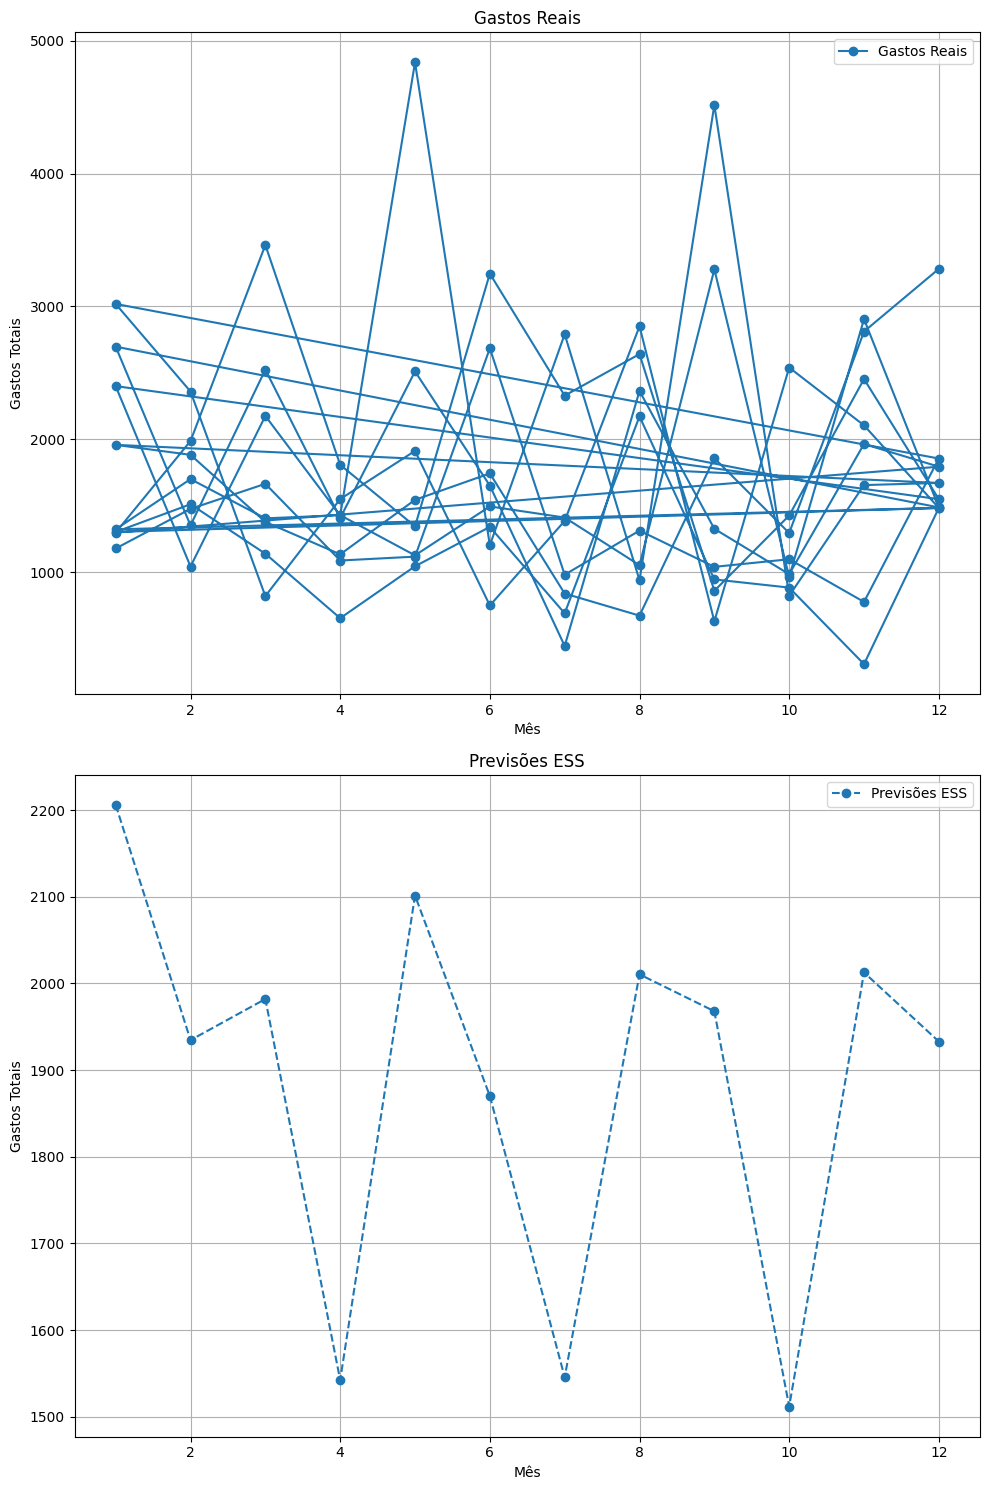

In [ ]:
# Plote os dados reais
fig, axs = plt.subplots(2, 1, figsize=(10, 15))  # Cria 3 subplots empilhados verticalmente

# Subplot 1: Gastos Reais
axs[0].plot(df_total_expenses_jian['month'], df_total_expenses_jian['total_expenses'], label='Gastos Reais', marker='o')
axs[0].set_xlabel('Mês')
axs[0].set_ylabel('Gastos Totais')
axs[0].set_title('Gastos Reais')
axs[0].grid(True)
axs[0].legend()

# Subplot 2: Previsões ESS
axs[1].plot(df_total_expenses_jian['month'].unique(), predictions_ess_jian, label='Previsões ESS', linestyle='--', marker='o')
axs[1].set_xlabel('Mês')
axs[1].set_ylabel('Gastos Totais')
axs[1].set_title('Previsões ESS')
axs[1].grid(True)
axs[1].legend()

plt.tight_layout()  # Garante que os subplots não se sobreponham
plt.show()

In [ ]:
print(predictions_ess_jian)

96     2206.063842
97     1934.623512
98     1982.032515
99     1542.309248
100    2101.448167
101    1870.090828
102    1545.593832
103    2010.533240
104    1967.942384
105    1511.645342
106    2012.738556
107    1932.991192
dtype: float64


#### Previsão de Gastos por Categoria

In [ ]:
df_soma_por_categoria_jian = df_jian.groupby(['year', 'month', 'product_category_name'])['price'].sum().reset_index()

In [ ]:
categorias = df_soma_por_categoria_jian['product_category_name'].value_counts().nlargest(10).index

In [ ]:
for categoria in categorias:
    df_categoria = df_soma_por_categoria_jian[df_soma_por_categoria_jian['product_category_name'] == categoria]
    prever_arima(categoria, df_categoria)

c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\beaso\AppData\Local

Previsão de Gastos para a Categoria "salao_barbearia" usando ARIMA (RMSE=194.54)
Previsão de Gastos para a Categoria "dentista" usando ARIMA (RMSE=189.94)
Previsão de Gastos para a Categoria "jardinagem" usando ARIMA (RMSE=75.29)
Previsão de Gastos para a Categoria "pet_shop" usando ARIMA (RMSE=305.10)


c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

Previsão de Gastos para a Categoria "mercadorias_em_geral" usando ARIMA (RMSE=63.24)
Previsão de Gastos para a Categoria "artigos_esportivos" usando ARIMA (RMSE=114.42)
Previsão de Gastos para a Categoria "medico" usando ARIMA (RMSE=87.22)
Previsão de Gastos para a Categoria "estacionamento" usando ARIMA (RMSE=127.74)


c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\beaso\AppData\Local

Previsão de Gastos para a Categoria "academia" usando ARIMA (RMSE=139.31)
Previsão de Gastos para a Categoria "moveis_decoracao" usando ARIMA (RMSE=108.21)


c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

In [ ]:
categorias2 = df_jian['product_category_name'].value_counts().nlargest(10).index

In [ ]:
for categoria in categorias2:
    df_categoria = df_soma_por_categoria_jian[df_soma_por_categoria_jian['product_category_name'] == categoria]
    prever_arima(categoria, df_categoria)

c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\beaso\AppData\Local

Previsão de Gastos para a Categoria "salao_barbearia" usando ARIMA (RMSE=194.54) 25    261.495016
26    265.828603
27    266.037258
28    266.047304
29    266.047788
30    266.047811
31    266.047812
Name: predicted_mean, dtype: float64
Previsão de Gastos para a Categoria "jardinagem" usando ARIMA (RMSE=75.29) 24    140.942741
25    144.362832
26    144.496784
27    144.502030
28    144.502236
29    144.502244
Name: predicted_mean, dtype: float64
Previsão de Gastos para a Categoria "artigos_esportivos" usando ARIMA (RMSE=114.42) 23    152.326572
24    173.485876
25    165.550942
26    168.526615
27    167.410711
28    167.829185
Name: predicted_mean, dtype: float64
Previsão de Gastos para a Categoria "dentista" usando ARIMA (RMSE=189.94) 24    267.443032
25    274.544051
26    273.139351
27    273.417224
28    273.362256
29    273.373130
30    273.370979
Name: predicted_mean, dtype: float64


c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin

Previsão de Gastos para a Categoria "hospedagem" usando ARIMA (RMSE=284.75) 20    200.935410
21    199.931169
22    199.882578
23    199.880227
24    199.880113
Name: predicted_mean, dtype: float64
Previsão de Gastos para a Categoria "medico" usando ARIMA (RMSE=87.22) 23    155.389143
24    158.306670
25    157.731959
26    157.845169
27    157.822868
28    157.827261
Name: predicted_mean, dtype: float64
Previsão de Gastos para a Categoria "academia" usando ARIMA (RMSE=139.31) 22    160.308935
23    151.207982
24    153.383131
25    152.863265
26    152.987515
27    152.957819
Name: predicted_mean, dtype: float64
Previsão de Gastos para a Categoria "moveis_decoracao" usando ARIMA (RMSE=108.21) 21    176.157829
22    152.643543
23    157.292372
24    156.373288
25    156.554993
26    156.519069
Name: predicted_mean, dtype: float64
Previsão de Gastos para a Categoria "pet_shop" usando ARIMA (RMSE=305.10) 24    475.548365
25    418.886058
26    427.592383
27    426.254631
28    426.460181

c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\beaso\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecastin